In [1]:
## -- Check for 3rd party libraries (tpu) --
try:
    import lightgbm as lgb
except:
    %pip install -q lightgbm
    import lightgbm as lgb

In [2]:
!pip show xgboost

Name: xgboost
Version: 3.1.0
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: TPOT


In [3]:
## -- System dependencies --
import sys, os, gc
import torch

## -- Device-Agnostic for GPU --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
    # get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    # get_ipython().run_line_magic('load_ext', 'cuml.accel')
    # from cuml.preprocessing import TargetEncoder as cuTE
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")

ℹ️ Device: CPU 4 cores


In [4]:
## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
import itertools

## -- Machine Learning --
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

import warnings

In [5]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use("ggplot")

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [6]:
## -- Load Data --
PATH = '/kaggle/input/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/datasets/sylvesterdalmeida/myheart-disease-dataset/'
# ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [7]:
# ## -- Load data from Colab --
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/--colab--notebooks--/Ps6e1 | Student Test Score/student_test_dataset/'
# submit = pd.read_csv(PATH+'sample_submission.csv')
# train = pd.read_csv(PATH+'train.csv').drop('id', axis=1)
# test = pd.read_csv(PATH+'test.csv').drop('id', axis=1)
# orig = pd.read_csv(PATH+'Exam_Score_Prediction.csv').drop('student_id', axis=1)

# TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# BASE = NUMS + CATS

# for (name, df) in dict(Train=train, Test=test, Original=orig).items():
#     print(f"{name} shape: {df.shape}")

# print(f"\nTotal Numerical: {len(NUMS)}")
# print(f"Total Categorical: {len(CATS)}")
# print(f"Total base features: {len(BASE)}")

In [8]:
display(train.head())
train.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: f

In [9]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient()

,Age,BP,Cholesterol,Max HR,ST depression,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,Slope of ST,Number of vessels fluro,Thallium
Train,42,66,150,93,66,2,4,2,3,2,3,4,3
Original,41,47,144,90,39,2,4,2,3,2,3,4,3
Test,43,64,145,92,64,2,4,2,3,2,3,4,3


## FEATURE ENGINEERING

In [10]:
# ## -- Factorize using combined data --
# for c in CATS:
#     combine  = pd.concat([train[c], test[c], orig[c]])
#     combine  = combine.factorize()[0]
#     train[c] = combine[:len(train)]
#     test[c]  = combine[len(train):len(train)+len(test)]
#     orig[c]  = combine[-len(orig):]

# ## -- Treat age(8 unique values) as category --
# NUMS.remove('age')
# CATS.append('age')

# print('Label encoding complete!')

In [11]:
# ## -- Append predicted columns as extra features --
# ## -- os.walk: Deep search with subfolders --
# def dataloader(filepath):    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
    
#     # print("Loading .npy: ", end="")
#     # for (root, dirs, files) in os.walk(filepath):
#     #     for i, file in enumerate(sorted(files), 1):
#     #         if i%5 == 0: print(f"{i}%.. ", end="")
#     #         if file.endswith(".npy") and "train" in file:
#     #             train_path = np.load(os.path.join(root, file))
#     #             train = pd.concat([train, pd.Series(train_path, name=file[6:-4])], axis=1)
#     #         elif file.endswith(".npy") and "test" in file:
#     #             test_path = np.load(os.path.join(root, file))
#     #             test = pd.concat([test, pd.Series(test_path, name=file[5:-4])], axis=1)
#     # print()
#     print("Loading .parquet files: ", end="")
#     for (root, dirs, files) in os.walk(filepath):
#         for i, file in enumerate(sorted(files), 1):
#             if i%5 == 0: print(f"{i}%.. ", end="")
#             if file.endswith(".parquet") and "train" in file:
#                 train_path = os.path.join(root, file)
#                 train_df = pd.concat([train_df, pd.read_parquet(train_path)], axis=1)
#             elif file.endswith(".parquet") and "test" in file:
#                 test_path = os.path.join(root, file)
#                 test_df = pd.concat([test_df, pd.read_parquet(test_path)], axis=1)
#     print()
#     print(f"Total train models: {len(train_df.columns)} || Shape: {train_df.shape}")
#     print(f"Total test models : {len(test_df.columns)} || Shape: {test_df.shape}")
#     print()

#     return train_df, test_df

In [12]:
# PATHS = [
#     # '/kaggle/input/ps6e1-per-feature-ag',
#     '/kaggle/input/ps6e1-autogluon-trainorig',
#     # '/kaggle/input/ps6e1-lr-gbdt-nn-trainorig',
# ]

# ## -- Load dataframes --
# train_dfs = []
# test_dfs  = []

# ## -- Load train/test datasets --
# for p in PATHS:
#     tr, ts = dataloader(p)
#     train_dfs.append(tr)
#     test_dfs.append(ts)

# ## -- Concat datasets --
# ext_train = pd.concat(train_dfs, axis=1)
# ext_test  = pd.concat(test_dfs, axis=1)

# print('External data loaded', ext_train.shape, ext_test.shape)

# ## -- Drop weighted autogluon models --
# for c in ext_train.columns:
#     if 'L2' in c or 'L3' in c: # 
#         ext_train.drop([c], axis=1, inplace=True)
#         ext_test.drop([c], axis=1, inplace=True)
#     elif c == TARGET:
#         ext_train.drop([c], axis=1, inplace=True)
    
# ## -- Check for missing values --
# print('Check missingness:', ext_train.isna().sum().sum(), ext_test.isna().sum().sum())

# display(ext_train.head(3))
# display(ext_test.head(3))

In [13]:
# %%time

# plt.figure(figsize=(18, 5))
# ext_train.boxplot()
# # sns.boxplot(ext_train)
# plt.tick_params(axis='x', rotation=90)

In [14]:
# ## -- Merge datasets --
# top_cols = ext_train.columns.tolist()

# train = pd.concat([train, ext_train], axis=1)
# test = pd.concat([test, ext_test], axis=1)

# train.head(3)

In [15]:
# for df_temp in [train, test, orig]:

    # df_temp['study_hours_squared'] = df_temp['study_hours'] ** 2
    # df_temp['study_hours_cubed'] = df_temp['study_hours'] ** 3
    # df_temp['class_attendance_squared'] = df_temp['class_attendance'] ** 2
    # df_temp['sleep_hours_squared'] = df_temp['sleep_hours'] ** 2
    # df_temp['age_squared'] = df_temp['age'] ** 2

    # df_temp['log_study_hours'] = np.log1p(df_temp['study_hours'])
    # df_temp['log_class_attendance'] = np.log1p(df_temp['class_attendance'])
    # df_temp['log_sleep_hours'] = np.log1p(df_temp['sleep_hours'])
    # df_temp['sqrt_study_hours'] = np.sqrt(df_temp['study_hours'])
    # df_temp['sqrt_class_attendance'] = np.sqrt(df_temp['class_attendance'])

    ## -- Interaction features --
    # df_temp['study_hours_times_attendance'] = df_temp['study_hours'] * df_temp['class_attendance']
    # df_temp['study_hours_times_sleep'] = df_temp['study_hours'] * df_temp['sleep_hours']
    # df_temp['attendance_times_sleep'] = df_temp['class_attendance'] * df_temp['sleep_hours']

    ## -- Ratio features (add small epsilon to avoid division by zero) --
    # eps = 1e-6
    # df_temp['study_hours_over_sleep'] = df_temp['study_hours'] / (df_temp['sleep_hours'] + eps)
    # df_temp['attendance_over_sleep'] = df_temp['class_attendance'] / (df_temp['sleep_hours'] + eps)

    ## -- Interaction between encoded categoricals and key numeric features --
    # df_temp['study_hours_times_sleep_quality'] = df_temp['study_hours'] * df_temp['sleep_quality']
    # df_temp['attendance_times_facility'] = df_temp['class_attendance'] * df_temp['facility_rating']
    # df_temp['sleep_hours_times_difficulty'] = df_temp['sleep_hours'] * df_temp['exam_difficulty']
    # df_temp['age_times_study_hours'] = df_temp['age'] * df_temp['study_hours']
    # df_temp['age_times_attendance'] = df_temp['age'] * df_temp['class_attendance']

    # ## -- Composite feature: learning efficiency --
    # df_temp['efficiency'] = (df_temp['study_hours'] * df_temp['class_attendance']) / (df_temp['sleep_hours'] + 1)
    # df_temp["study_efficiency"] = df_temp["study_hours"] * (df_temp["class_attendance"] / 100.0)

    # ## -- Cyclic encoding --
    # for p in [12, 14]:
    #     df_temp[f"study_hours_sin_{p}"] = np.sin(2 * np.pi * df_temp['study_hours'] / p).astype('float32')
    #     df_temp[f"class_attend_sin_{p}"] = np.sin(2 * np.pi * df_temp['class_attendance'] / p).astype('float32')

    # total_features = [c for c in df_temp.columns if c != TARGET]
    # print(f'Feature Engineered: {len(total_features)}')

In [16]:
# ## -- Create 'meta' feature --
# ## -- https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915
# def meta_feature(df):
#     formula = (
#         6 * df.study_hours + \
#         0.35 * df.class_attendance + \
#         1.5 * df.sleep_hours + \
#         5 * (df.sleep_quality=='good') + \
#         -5 * (df.sleep_quality=='poor') + \
#         10 * (df.study_method=='coaching') + \
#         5 * (df.study_method=='mixed') + \
#         2 * (df.study_method=='group study') + \
#         1 * (df.study_method=='online videos') + \
#         4 * (df.facility_rating=='high') + \
#         -4 * (df.facility_rating=='low')
#     )
#     return formula

# train['formula'] = meta_feature(train)
# test['formula'] = meta_feature(test)
# orig['formula'] = meta_feature(orig)

# ## -- Set ordinal mapping --
# ordinal_maps = {
#     "internet_access": {"no":0, "yes":1},
#     "gender": {"male":0, "female":1, "other":2},
#     "sleep_quality": {"poor":0, "average":1, "good":2},
#     "facility_rating": {"low":0, "medium":1, "high":2},
#     "exam_difficulty": {"easy":0, "moderate":1, "hard":2},
#     "course": {"ba":0, "b.sc":1, "diploma":2, "b.tech":3, "b.com":4, "bca":5, "bba":6},
#     "study_method": {"self-study":0, "online videos":1, "group study":2, "mixed":3, "coaching":4},
# }

# for c in CATS:
#     train[c] = train[c].map(ordinal_maps[c]).fillna(-1)
#     test[c] = test[c].map(ordinal_maps[c]).fillna(-1)
#     orig[c] = orig[c].map(ordinal_maps[c]).fillna(-1)

# print("Feature 'formula' and ordinal label encoded")

In [17]:
# ## -- Duplicate all features as categories --
# # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]
# CATS_2 = []

# for c in NUMS:
#     n = f"cat_{c}"
#     train[n] = train[c].copy()
#     test[n]  = test[c].copy()
#     orig[n]  = orig[c].copy()
#     CATS_2.append(n)

#     ## -- FACTORIZE CATS_2 --
#     combine  = pd.concat([train[n], test[n], orig[n]])
#     v, _ = combine.factorize()
#     train[n] = v[:len(train)].astype('int32')
#     test[n]  = v[len(train):len(train)+len(test)].astype('int32')
#     orig[n]  = v[len(train)+len(test):].astype('int32')

# print(f'NUMS TO CAT: {len(CATS_2)}')

# train.head(3)

In [18]:
# ## -- COMPUTE FREQUENCIES --
# FREQ_COLS = []

# for c in NUMS:
#     n = f"freq_{c}"
#     # Build the global domain from all three frames
#     all_vals = pd.concat([train[c], test[c], orig[c]], axis=0)

#     # Compute normalized value counts (frequency) on the global domain
#     freq = all_vals.value_counts(normalize=True)

#     # Map each frame using the global frequency domain
#     train[n] = train[c].map(freq).fillna(0).astype('float32')
#     test[n]  = test[c].map(freq).fillna(0).astype('float32')
#     orig[n]  = orig[c].map(freq).fillna(0).astype('float32')

#     FREQ_COLS.append(n)

# print(f'NUMS TO FREQUENCIES: {len(FREQ_COLS)}')

# train.head(3)

In [19]:
# ## -- Extract Digits --
# DIGITS = []

# for col in tqdm(NUMS):
#     for d in range(-3, 4):
#         n = f'{col}_d{d}'
#         train[n] = ((train[col] * 10**d) % 10).fillna(-1).astype('int32')
#         test[n]  = ((test[col]  * 10**d) % 10).fillna(-1).astype('int32')
#         orig[n]  = ((orig[col]  * 10**d) % 10).fillna(-1).astype('int32')

#         ## -- Drop constant features --
#         if train[n].nunique() < 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             DIGITS.append(n)

# print(f'{len(DIGITS)} Feature DIGITS extracted.')
# print(train[DIGITS].nunique())

# # train = train.drop(DIGITS, axis=1)
# # test  = test.drop(DIGITS, axis=1)

In [20]:
# for k, v in dict(w3_0d=158, w2_0d=42, w1_1d=9.4, w2_1d=92.6, w1_2d=6.59).items():
#     print(f'{k:<6}| ---------------')
#     for i in range(-2, 2):
#         print(f'Round_{i:<2}: {v} = {np.round(v, i)}')

In [21]:
# # DOUBLES = [c for c in BASE if train_df[c].dtype == 'float']
# ROUND = []

# for col in tqdm(HIGH_CAD_COLS): # +['formula']
#     for r in range(-3, 2):
#         n = f"{col}_r{r}"
#         train[n] = train[col].round(r).astype('int32')
#         test[n]  = test[col].round(r).astype('int32')
#         orig[n]  = test[col].round(r).astype('int32')

#         ## -- Drop irrelevant features --
#         if train[n].nunique() <= 2:
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         elif train[n].nunique() == train[c].nunique():
#             train.drop([n], axis=1, inplace=True)
#             test.drop([n],  axis=1, inplace=True)
#             orig.drop([n],  axis=1, inplace=True)
#         else:
#             ROUND.append(n)

# print(f'Total ROUNDed Features: {len(ROUND)}')
# print(train[ROUND].nunique())

In [22]:
# ## -- Round values to keep --
# ROUND = ['Age_r1','BP_r-1','Cholesterol_r-2','Cholesterol_r-1','Max HR_r-1','ST depression_r0','ST depression_r1']
# ROUND

In [23]:
# INTER = []

# for c1, c2 in tqdm(list(itertools.combinations(['Age', 'ST depression'], 2)), desc='Pairwise'):
#     n_col = f"{c1}-|-{c2}"
#     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
#     test[n_col]  = test[c1].astype(str) + '_' + test[c2].astype(str)
#     orig[n_col]  = orig[c1].astype(str) + '_' + orig[c2].astype(str)

#     train[n_col] = train[n_col].astype('category')
#     cat          = train[n_col].cat
#     train[n_col] = train[n_col].cat.codes
#     test[n_col]  = pd.Categorical(test[n_col], categories=cat.categories).codes
#     orig[n_col]  = pd.Categorical(orig[n_col], categories=cat.categories).codes

#     INTER.append(n_col)

# # for c1, c2, c3 in tqdm(list(combinations(TOP_PREDICTORS+TOP_PREDICTORS_2, 3)), desc='Triplewise'):
# #     n_col = f"{c1}-|-{c2}-|-{c3}"
# #     train[n_col] = train[c1].astype(str) + '_' + train[c2].astype(str) + '_' + train[c3].astype(str)
# #     test[n_col] = test[c1].astype(str) + '_' + test[c2].astype(str) + '_' + test[c3].astype(str)
# #     INTER.append(n_col)

# # for c1, c2 in tqdm(list(product(TOP_PREDICTORS, OTHER_PREDICTORS)), desc='1-to-many Pairwise'):
# #     new_col = f"{c1}-|-{c2}"
# #     train[new_col] = train[c1].astype(str) + '_' + train[c2].astype(str)
# #     test[new_col] = test[c1].astype(str) + '_' + test[c2].astype(str)
# #     orig[new_col] = orig[c1].astype(str) + '_' + orig[c2].astype(str)
# #     INTER.append(new_col)

# print(f"Interaction Features: {len(INTER)}")

In [24]:
def orig_TE_data_propagate(
    orig: pd.DataFrame,
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    features: list = None,
    aggs: list = None,
    fill_nan: bool = False,
):

    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"
            
            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET].mean()
                                  .reset_index(name=new_col)
                                  # .fillna(orig[col].mean())
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(orig[col].mean())
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET].median()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(orig[col].median())
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET].nunique()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET].std()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET].skew()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[new_col].fillna(0)
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET]
                                  .max()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[TARGET].mean()
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET]
                                  .min()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                        # map_df[new_col] = map_df[TARGET].mean()
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    global_mean   = orig[TARGET].mean()
    global_median = orig[TARGET].median()
    
    def fill_conditionally(df):
        for c in ORIG:
            if '_mean' in c or '_max' in c or '_min' in c:
                df[c] = df[c].fillna(global_mean)
            elif '_median' in c:
                df[c] = df[c].fillna(global_median)
            else:
                df[c] = df[c].fillna(0)
        return df

    if fill_nan:
        X_train_df = fill_conditionally(X_train_df)
        X_val_df   = fill_conditionally(X_val_df)
        X_test_df  = fill_conditionally(X_test_df)

    return X_train_df, X_val_df, X_test_df, ORIG

In [25]:
# train, test, dummy, NEW_COLS = orig_TE_data_propagate(
#     orig,
#     train,
#     test,
#     train.iloc[:500],
#     features = BASE,
#     aggs = ['count'],# 'std']# 'nunique']#'median']#,], 'max'
#     # fill_nan=True,
# )

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin ## ===== Target/Category Mean ENCODERS =====

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique',
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the
        global mean. If 'auto', an empirical Bayes estimate is used.

    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping

        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)

        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)

        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]

            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'

                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)

                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()

                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups

                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)

                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]

        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)

        return X_transformed


class CategoryMeanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols=None):
        self.cat_cols = cat_cols
        self.mappings_ = {}
    def fit(self, X, y):
        X = X.copy()
        if self.cat_cols is None:
            self.cat_cols = X.select_dtypes(include=['category']).columns.tolist()
        self.mappings_ = {}
        for col in self.cat_cols:
            df_temp = pd.DataFrame({col: X[col], 'y': y})
            group_means = df_temp.groupby(col, dropna=False)['y'].mean()
            sorted_categories = group_means.sort_values().index
            self.mappings_[col] = {cat: i for i, cat in enumerate(sorted_categories)}
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for col, mapping in self.mappings_.items():
            if col in X.columns:
                X[col] = X[col].map(mapping)
        return X

In [27]:
FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('Total Features:', len(FEATURES))

train.head(3)

Total Features: 13


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


# ML TRAINING

In [28]:
def Trainer_CV(model_name, params, train_df, test_df, features, target, kf, cats):

    print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

    start = time()
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    fold_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
        print(f"\n- Fold {idx + 1}/{kf.n_splits} | ", end='')

        ## -- Split data for the current fold
        X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
        y_train, y_val = train_df.loc[train_idx, target].values, train_df.loc[val_idx, target].values

        X_test = test_df[features].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        # BINS = []
        # print(f"\nCreating bins... ", end="")
        # for c in ['BP', 'Cholesterol']:
        #     for b in [5]:
        #         print(f"{c}_{b}, ", end="")
        #         b_n = f'{c}_bin{b}'
        #         # Fit on train data and transform both train and test
        #         bins = np.linspace(X_train[c].min(), X_train[c].max(), b+1)
        #         X_train[b_n] = pd.cut(X_train[c], include_lowest=True, labels=False, bins=bins)
        #         X_val[b_n]   = pd.cut(X_val[c], include_lowest=True, labels=False, bins=bins)
        #         X_test[b_n]  = pd.cut(X_test[c], include_lowest=True, labels=False, bins=bins)
        #         BINS.append(b_n)
        # print()
        # print(f"✅ TOTAL BINNED FEATURES: {len(BINS)}")

        # ## -- TE Opt1. -> Using CUSTOM --
        # TE = TargetEncoder(BINS, cv=5, smooth='auto', aggs=['mean'], drop_original=True)
        # X_train = TE.fit_transform(X_train, pd.Series(y_train))
        # X_val   = TE.transform(X_val)
        # X_test  = TE.transform(X_test)
        
        ## -- OPTION B: TE Merge original data --
        X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
            orig,
            X_train,
            X_val,
            X_test,
            features = BASE,
            aggs = ['count'], # mean, median, count, std, nunique, max, min
            # fill_nan=True,
        )

        CME_CATS = NUMS
        cme_cols = []

        print(f"CategoryMeanEncoding: {len(CME_CATS)} | ", end='')
        for c in CME_CATS:
            n = f"CME_{c}"
            CME = CategoryMeanTransformer(cat_cols=[c])
            X_train[n] = CME.fit_transform(X_train[[c]], y_train).fillna(-1)
            X_val[n]   = CME.transform(X_val[[c]]).fillna(-1)
            X_test[n]  = CME.transform(X_test[[c]]).fillna(-1)
            cme_cols.append(n)

        ## -- TE Opt1. -> Using CUSTOM --
        TE = TargetEncoder(cme_cols, cv=5, smooth='auto', aggs=['mean'], drop_original=True)
        X_train = TE.fit_transform(X_train, pd.Series(y_train))
        X_val   = TE.transform(X_val)
        X_test  = TE.transform(X_test)
        
        combined = pd.concat([X_train, X_val, X_test])

        for c in cats:
            combined[c] = combined[c].astype('category')

        X_train = combined.iloc[:len(X_train)]
        X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combined.iloc[len(X_train)+len(X_val):]

        print(f"Train shape: {X_train.shape} -")

        dtrain = lgb.Dataset(X_train, y_train)
        dval   = lgb.Dataset(X_val, y_val, reference=dtrain)
        # dtest  = lgb.Dataset(X_test)

        eval_result = {}
        all_eval_results = []

        model = lgb.train( 
            params,
            dtrain,
            num_boost_round = 50_000,
            valid_sets = [dtrain, dval],
            valid_names = ['train', 'valid'],
            callbacks=[lgb.early_stopping(500), lgb.log_evaluation(1000), lgb.record_evaluation(eval_result)],
        )
        
        all_eval_results.append(eval_result)
        
        ## -- Predict on validation and test sets --
        oof_preds[val_idx] = model.predict(X_val).ravel()
        test_preds += model.predict(X_test).ravel()

        ## -- Calculate and print fold score --
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(fold_auc)
        print(f'Fold {idx+1} AUC: {fold_auc:.6f}')
        
        ## -- Clean up memory --
        del X_train, y_train, y_val, X_test, dtrain, dval
        gc.collect()

    ## -- Average the test predictions --
    test_preds /= kf.n_splits

    ## -- Print final cross-validation results --
    print("\n==================================================")
    print(f"Cross-Validation Results for {model_name}")
    print("==================================================")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1} AUC: {score:.6f}")
    
    ## -- Calculate and print the final out-of-fold AUC --
    oof_auc = np.round(roc_auc_score(train_df[target], oof_preds), 6)
    
    print("-------------------------------------------------|")
    print(f"Overall AUC: {oof_auc}")
    print(f"Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print("-------------------------------------------------|")
    print(f'{((time() - start) / 60):.2f} mins\n')
    
    return {
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'score': oof_auc,
        'model': model,
        'records': all_eval_results,
        'val_data': X_val,
    }

print('⚙️⚙️ Training function ready ⚙️⚙️')

⚙️⚙️ Training function ready ⚙️⚙️


In [29]:
# def run_cross_validation(model_name, model_instance, train_df, test_df, features, target, kf, cats):

#     print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

#     oof_preds = np.zeros(len(train_df))
#     test_preds = np.zeros(len(test_df))
#     fold_scores = []

#     for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
#         print(f"\n- Fold {idx + 1}/{kf.n_splits} -", end='')
        
#         # Split data for the current fold
#         X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
#         y_train, y_val = train_df.loc[train_idx, target], train_df.loc[val_idx, target]
        
#         X_test = test_df[features].copy()
        
#         X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
#         y_train = np.concatenate([y_train.values, orig[TARGET].values], axis=0)

#         ## -- TE Opt1. -> Using CUSTOM --
#         TE = TargetEncoder(ROUND, cv=5, smooth='auto', aggs=['mean'], drop_original=True)
#         X_train = TE.fit_transform(X_train, pd.Series(y_train))
#         X_val   = TE.transform(X_val)
#         X_test  = TE.transform(X_test)
        
#         # ## -- TE Opt2. -- Using RAPIDS 
#         # for c in ROUND:
#         #     TE = cuTE(n_folds=5, smooth=0.05, stat='mean', split_method='random', seed=SEED)
#         #     n = f"TE_{c}"
#         #     X_train[n] = TE.fit_transform(X_train[c], y_train)
#         #     X_val[n]   = TE.transform(X_val[c])
#         #     X_test[n]  = TE.transform(X_test[c])
#         #     for df in [X_train, X_val, X_test]:
#         #         df.drop([c], axis=1, inplace=True)
    
#         combined = pd.concat([X_train, X_val, X_test])
#         for c in cats:
#             combined[c] = combined[c].astype('category')
#         X_train = combined.iloc[:len(X_train)]
#         X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
#         X_test  = combined.iloc[len(X_train)+len(X_val):]

#         print(f"Train shape: {X_train.shape} -")

#         # Fit the model
#         model_instance.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=500)
        
#         # Predict on validation and test sets
#         oof_preds[val_idx] = model_instance.predict(X_val).flatten()
#         test_preds += model_instance.predict(X_test).flatten()

#         # Calculate and print fold score
#         fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
#         fold_scores.append(fold_auc)
#         print(f'Fold {idx + 1} AUC: {fold_auc:.5f}')
        
#         # Clean up memory
#         del X_train, X_val, y_train, y_val, X_test
#         gc.collect()

#     # Average the test predictions
#     test_preds /= kf.n_splits
    
#     # Print final cross-validation results
#     print("\n==================================================")
#     print(f"Cross-Validation Results for {model_name}")
#     print("==================================================")
#     for i, score in enumerate(fold_scores):
#         print(f"Fold {i+1} AUC: {score:.5f}")
#     print(f"Mean AUC: {np.mean(fold_scores):.5f} ± {np.std(fold_scores):.5f}")
    
#     # Calculate and print the final out-of-fold AUC
#     oof_rmse = np.round(roc_auc_score(train_df[target], oof_preds), 5)
#     print("| ------------------------------------------------")
#     print(f"Final {kf.n_splits}-Fold CV AUC: {oof_rmse}")
#     print("==================================================")

#     return {
#         'oof_preds': oof_preds,
#         'test_preds': test_preds,
#         'score': oof_rmse
#     }

# print('⚙️⚙️ Training function ready ⚙️⚙️')

# m_name = 'XGB_gbdt2'
# PARAMS = {
#     # 'sampling_method': 'gradient_based',
#     # # ----------------------------------
#     # 'grow_policy': 'lossguide',
#     # 'max_leaves': 128,
#     'max_depth': 8, # 7 & 0 if lossguide
#     # ------------------------------------
#     'objective': 'reg:squarederror',
#     'eval_metric': 'auc',
#     'learning_rate': 0.1,
#     'subsample': 0.85,
#     'colsample_bytree': 0.35, # orig->0.35, ext1->0.3, ext2->0.3
#     'reg_lambda': 3.0,
#     'reg_alpha': 1.5,
#     'min_child_weight': 5,
#     'max_cat_to_onehot': 10,
#     'random_state': SEED,
#     'early_stopping_rounds': 200,
#     'enable_categorical': True,
#     'verbosity': 0,
#     'n_jobs': os.cpu_count(),
#     'device': 'cuda' if torch.cuda.is_available() else 'cpu',
# }

# model_XGB = xgb.XGBRegressor(**PARAMS)

# all_model_predictions[m_name] = run_cross_validation(
#     model_name=m_name,
#     model_instance=model_XGB,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS_2+DIGITS
# ) 

In [30]:
all_model_predictions = {}

SEED_2 = 777
SEED_3 = 1234
SEED_4 = 24611
SEED_5 = 0

N_SPLITS = 15
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

kf

StratifiedKFold(n_splits=15, random_state=42, shuffle=True)

In [31]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """

# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'Trial_'
# LR = 0.05
# LEAVES = 31
# LOOP = [0.1]

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")
#     PARAMS = {
#         # 'boosting': 'dart',
#         # ---------------------------------
#         # 'data_sample_strategy': 'goss', 
#         # 'top_rate': 0.7,
#         # 'other_rate': 0.2,
#         # ---------------------------------
#         'objective': 'binary',
#         'eval_metric': 'auc',
#         'learning_rate': LR,
#         'max_leaves': LEAVES,
#         'subsample': 0.8,
#         'colsample_bytree': 0.2, 
#         # 'reg_lambda': 0.0,
#         'reg_alpha': 3.5,
#         'random_state': SEED,
#         'verbosity': -1,
#         'n_jobs': os.cpu_count(),
#         'device': 'gpu' if torch.cuda.is_available() else 'cpu',
#     }

#     n = M_NAME + str(LEAVES) + '_' + str(value)

#     all_model_predictions[n] = Trainer_CV(
#         model_name=n,
#         params=PARAMS,
#         train_df=train,
#         test_df=test,
#         features=FEATURES,
#         target=TARGET,
#         kf=kf,
#         cats=CATS # + CATS_2
#     )

#     COMPILER.append(all_model_predictions)

# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

# # TE ONLY NUMS : SPLIT 5 : 0.05
# # -------------------------------------------------|
# # Overall AUC: 0.955633
# # Average AUC: 0.955635 ± 0.000491
# # -------------------------------------------------|
# # 3.77 mins

In [32]:
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 # print(k, y)
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(20, 6))
# # pd.Series(all_model_scores).plot(marker='o')
# sns.lineplot(all_model_scores, marker='o')
# plt.title('LGB Scores', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score-5e-7, score, ha='center', va='baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [33]:
version_name = 'LGBv2'

M_NAME = f"{version_name}BAG_"
LR = 0.01
REGULATE = 3.5
LEAVES = 31

PARAMS = {
    # 'boosting': 'dart',
    # ---------------------------------
    'objective': 'binary',
    'eval_metric': 'auc',
    'learning_rate': LR,
    'max_leaves': LEAVES,
    'subsample': 0.8,
    'colsample_bytree': 0.2,
    # 'reg_lambda': REGULATE,
    'reg_alpha': REGULATE,
    'random_state': SEED,
    'verbosity': -1,
    'n_jobs': os.cpu_count(),
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(LR).split('.')[1] + '_' +  str(SEED)
all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_2 # Update seed
n = M_NAME +  str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


PARAMS['random_state'] = SEED_3 # Update seed
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


PARAMS['random_state'] = SEED_4 # Update seed
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_5 # Update seed
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
) 


==================== Starting Cross-Validation for LGBv2BAG_01_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266737	valid's binary_logloss: 0.266673
[2000]	train's binary_logloss: 0.263825	valid's binary_logloss: 0.265414
[3000]	train's binary_logloss: 0.262304	valid's binary_logloss: 0.265395
Early stopping, best iteration is:
[3101]	train's binary_logloss: 0.262164	valid's binary_logloss: 0.26539
Fold 1 AUC: 0.956204

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266688	valid's binary_logloss: 0.267151
[2000]	train's binary_logloss: 0.263736	valid's binary_logloss: 0.26619
Early stopping, best iteration is:
[2004]	train's binary_logloss: 0.26373	valid's binary_logloss: 0.266189
Fold 2 AUC: 0.956085

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266686	valid's binary_logloss: 0.267345
[2000]	train's binary_logloss: 0.26375	valid's binary_logloss: 0.266012
[3000]	train's binary_logloss: 0.262208	valid's binary_logloss: 0.265997
Early stopping, best iteration is:
[2621]	train's binary_logloss: 0.26275	valid's binary_logloss: 0.265978
Fold 3 AUC: 0.955904

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266598	valid's binary_logloss: 0.268278
[2000]	train's binary_logloss: 0.263658	valid's binary_logloss: 0.267047
Early stopping, best iteration is:
[2060]	train's binary_logloss: 0.263547	valid's binary_logloss: 0.267042
Fold 4 AUC: 0.955624

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266286	valid's binary_logloss: 0.272734
[2000]	train's binary_logloss: 0.263365	valid's binary_logloss: 0.271761
Early stopping, best iteration is:
[1954]	train's binary_logloss: 0.263442	valid's binary_logloss: 0.271759
Fold 5 AUC: 0.954297

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266451	valid's binary_logloss: 0.270622
[2000]	train's binary_logloss: 0.263521	valid's binary_logloss: 0.269553
Early stopping, best iteration is:
[2233]	train's binary_logloss: 0.263123	valid's binary_logloss: 0.269539
Fold 6 AUC: 0.954808

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266659	valid's binary_logloss: 0.267404
[2000]	train's binary_logloss: 0.263725	valid's binary_logloss: 0.266425
Early stopping, best iteration is:
[2198]	train's binary_logloss: 0.263388	valid's binary_logloss: 0.266416
Fold 7 AUC: 0.955853

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266719	valid's binary_logloss: 0.267079
[2000]	train's binary_logloss: 0.263798	valid's binary_logloss: 0.265916
[3000]	train's binary_logloss: 0.262269	valid's binary_logloss: 0.265895
Early stopping, best iteration is:
[2596]	train's binary_logloss: 0.262844	valid's binary_logloss: 0.265883
Fold 8 AUC: 0.956084

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266588	valid's binary_logloss: 0.268784
[2000]	train's binary_logloss: 0.263683	valid's binary_logloss: 0.26777
[3000]	train's binary_logloss: 0.262161	valid's binary_logloss: 0.26778
Early stopping, best iteration is:
[2660]	train's binary_logloss: 0.262641	valid's binary_logloss: 0.267755
Fold 9 AUC: 0.955429

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266463	valid's binary_logloss: 0.270155
[2000]	train's binary_logloss: 0.263556	valid's binary_logloss: 0.269165
[3000]	train's binary_logloss: 0.262035	valid's binary_logloss: 0.269137
Early stopping, best iteration is:
[2669]	train's binary_logloss: 0.262492	valid's binary_logloss: 0.269124
Fold 10 AUC: 0.955024

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266476	valid's binary_logloss: 0.270507
[2000]	train's binary_logloss: 0.263566	valid's binary_logloss: 0.269264
[3000]	train's binary_logloss: 0.262035	valid's binary_logloss: 0.269287
Early stopping, best iteration is:
[2534]	train's binary_logloss: 0.262711	valid's binary_logloss: 0.269245
Fold 11 AUC: 0.954865

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266715	valid's binary_logloss: 0.266843
[2000]	train's binary_logloss: 0.263795	valid's binary_logloss: 0.265521
[3000]	train's binary_logloss: 0.262267	valid's binary_logloss: 0.265504
Early stopping, best iteration is:
[2690]	train's binary_logloss: 0.262701	valid's binary_logloss: 0.265476
Fold 12 AUC: 0.956270

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26686	valid's binary_logloss: 0.264726
[2000]	train's binary_logloss: 0.26392	valid's binary_logloss: 0.263405
[3000]	train's binary_logloss: 0.262375	valid's binary_logloss: 0.263413
Early stopping, best iteration is:
[2604]	train's binary_logloss: 0.262947	valid's binary_logloss: 0.263394
Fold 13 AUC: 0.956922

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26663	valid's binary_logloss: 0.267902
[2000]	train's binary_logloss: 0.263698	valid's binary_logloss: 0.266824
[3000]	train's binary_logloss: 0.262164	valid's binary_logloss: 0.266798
Early stopping, best iteration is:
[2615]	train's binary_logloss: 0.262715	valid's binary_logloss: 0.266778
Fold 14 AUC: 0.955771

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266702	valid's binary_logloss: 0.266838
[2000]	train's binary_logloss: 0.263763	valid's binary_logloss: 0.265836
Early stopping, best iteration is:
[2221]	train's binary_logloss: 0.263385	valid's binary_logloss: 0.26583
Fold 15 AUC: 0.956041

Cross-Validation Results for LGBv2BAG_01_42
Fold 1 AUC: 0.956204
Fold 2 AUC: 0.956085
Fold 3 AUC: 0.955904
Fold 4 AUC: 0.955624
Fold 5 AUC: 0.954297
Fold 6 AUC: 0.954808
Fold 7 AUC: 0.955853
Fold 8 AUC: 0.956084
Fold 9 AUC: 0.955429
Fold 10 AUC: 0.955024
Fold 11 AUC: 0.954865
Fold 12 AUC: 0.956270
Fold 13 AUC: 0.956922
Fold 14 AUC: 0.955771
Fold 15 AUC: 0.956041
-------------------------------------------------|
Overall AUC: 0.955676
Average AUC: 0.955679 ± 0.000660
-------------------------------------------------|
57.90 mins


==================== Starting Cross-Validation for LGBv2BAG_777 =========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266592	valid's binary_logloss: 0.266471
[2000]	train's binary_logloss: 0.263874	valid's binary_logloss: 0.265432
[3000]	train's binary_logloss: 0.262476	valid's binary_logloss: 0.265402
Early stopping, best iteration is:
[2632]	train's binary_logloss: 0.262957	valid's binary_logloss: 0.265394
Fold 1 AUC: 0.956214

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266541	valid's binary_logloss: 0.267112
[2000]	train's binary_logloss: 0.263809	valid's binary_logloss: 0.26613
Early stopping, best iteration is:
[1830]	train's binary_logloss: 0.264091	valid's binary_logloss: 0.266126
Fold 2 AUC: 0.956115

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266552	valid's binary_logloss: 0.267162
[2000]	train's binary_logloss: 0.263816	valid's binary_logloss: 0.266087
Early stopping, best iteration is:
[2096]	train's binary_logloss: 0.263669	valid's binary_logloss: 0.266084
Fold 3 AUC: 0.955877

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266481	valid's binary_logloss: 0.267799
[2000]	train's binary_logloss: 0.263723	valid's binary_logloss: 0.266952
Early stopping, best iteration is:
[1958]	train's binary_logloss: 0.263789	valid's binary_logloss: 0.266944
Fold 4 AUC: 0.955651

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266159	valid's binary_logloss: 0.272318
[2000]	train's binary_logloss: 0.263426	valid's binary_logloss: 0.271665
Early stopping, best iteration is:
[1802]	train's binary_logloss: 0.263759	valid's binary_logloss: 0.271658
Fold 5 AUC: 0.954320

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266338	valid's binary_logloss: 0.27016
[2000]	train's binary_logloss: 0.263597	valid's binary_logloss: 0.269428
Early stopping, best iteration is:
[1855]	train's binary_logloss: 0.263839	valid's binary_logloss: 0.269426
Fold 6 AUC: 0.954841

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266536	valid's binary_logloss: 0.267188
[2000]	train's binary_logloss: 0.263778	valid's binary_logloss: 0.266375
Early stopping, best iteration is:
[2148]	train's binary_logloss: 0.263544	valid's binary_logloss: 0.266359
Fold 7 AUC: 0.955882

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266575	valid's binary_logloss: 0.266996
[2000]	train's binary_logloss: 0.263841	valid's binary_logloss: 0.265914
[3000]	train's binary_logloss: 0.262426	valid's binary_logloss: 0.265876
Early stopping, best iteration is:
[2746]	train's binary_logloss: 0.262764	valid's binary_logloss: 0.265857
Fold 8 AUC: 0.956091

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266446	valid's binary_logloss: 0.269091
[2000]	train's binary_logloss: 0.263731	valid's binary_logloss: 0.267917
[3000]	train's binary_logloss: 0.262318	valid's binary_logloss: 0.267914
Early stopping, best iteration is:
[2534]	train's binary_logloss: 0.262936	valid's binary_logloss: 0.267872
Fold 9 AUC: 0.955392

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266321	valid's binary_logloss: 0.270112
[2000]	train's binary_logloss: 0.263598	valid's binary_logloss: 0.269252
Early stopping, best iteration is:
[2051]	train's binary_logloss: 0.263514	valid's binary_logloss: 0.269246
Fold 10 AUC: 0.954987

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266352	valid's binary_logloss: 0.270244
[2000]	train's binary_logloss: 0.263635	valid's binary_logloss: 0.269228
Early stopping, best iteration is:
[2166]	train's binary_logloss: 0.263373	valid's binary_logloss: 0.269219
Fold 11 AUC: 0.954871

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266603	valid's binary_logloss: 0.266718
[2000]	train's binary_logloss: 0.263879	valid's binary_logloss: 0.265532
[3000]	train's binary_logloss: 0.262449	valid's binary_logloss: 0.265527
Early stopping, best iteration is:
[2807]	train's binary_logloss: 0.262709	valid's binary_logloss: 0.265515
Fold 12 AUC: 0.956256

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266729	valid's binary_logloss: 0.264819
[2000]	train's binary_logloss: 0.263994	valid's binary_logloss: 0.263384
[3000]	train's binary_logloss: 0.262593	valid's binary_logloss: 0.263329
Early stopping, best iteration is:
[2685]	train's binary_logloss: 0.263007	valid's binary_logloss: 0.263305
Fold 13 AUC: 0.956953

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266508	valid's binary_logloss: 0.267637
[2000]	train's binary_logloss: 0.263759	valid's binary_logloss: 0.266619
Early stopping, best iteration is:
[2403]	train's binary_logloss: 0.263155	valid's binary_logloss: 0.2666
Fold 14 AUC: 0.955836

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266565	valid's binary_logloss: 0.267068
[2000]	train's binary_logloss: 0.263821	valid's binary_logloss: 0.266018
Early stopping, best iteration is:
[2304]	train's binary_logloss: 0.263354	valid's binary_logloss: 0.265994
Fold 15 AUC: 0.955986

Cross-Validation Results for LGBv2BAG_777
Fold 1 AUC: 0.956214
Fold 2 AUC: 0.956115
Fold 3 AUC: 0.955877
Fold 4 AUC: 0.955651
Fold 5 AUC: 0.954320
Fold 6 AUC: 0.954841
Fold 7 AUC: 0.955882
Fold 8 AUC: 0.956091
Fold 9 AUC: 0.955392
Fold 10 AUC: 0.954987
Fold 11 AUC: 0.954871
Fold 12 AUC: 0.956256
Fold 13 AUC: 0.956953
Fold 14 AUC: 0.955836
Fold 15 AUC: 0.955986
-------------------------------------------------|
Overall AUC: 0.955682
Average AUC: 0.955685 ± 0.000661
-------------------------------------------------|
55.03 mins


==================== Starting Cross-Validation for LGBv2BAG_1234 =========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266632	valid's binary_logloss: 0.266584
[2000]	train's binary_logloss: 0.263826	valid's binary_logloss: 0.265424
Early stopping, best iteration is:
[2346]	train's binary_logloss: 0.263255	valid's binary_logloss: 0.265399
Fold 1 AUC: 0.956201

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266578	valid's binary_logloss: 0.267055
[2000]	train's binary_logloss: 0.263733	valid's binary_logloss: 0.266193
Early stopping, best iteration is:
[1973]	train's binary_logloss: 0.263781	valid's binary_logloss: 0.26619
Fold 2 AUC: 0.956080

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266569	valid's binary_logloss: 0.267309
[2000]	train's binary_logloss: 0.263737	valid's binary_logloss: 0.266131
[3000]	train's binary_logloss: 0.262196	valid's binary_logloss: 0.266095
Early stopping, best iteration is:
[2531]	train's binary_logloss: 0.262883	valid's binary_logloss: 0.266083
Fold 3 AUC: 0.955878

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266494	valid's binary_logloss: 0.26814
[2000]	train's binary_logloss: 0.263657	valid's binary_logloss: 0.267013
Early stopping, best iteration is:
[2392]	train's binary_logloss: 0.263025	valid's binary_logloss: 0.266995
Fold 4 AUC: 0.955638

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266188	valid's binary_logloss: 0.272618
[2000]	train's binary_logloss: 0.263347	valid's binary_logloss: 0.271737
Early stopping, best iteration is:
[2130]	train's binary_logloss: 0.263118	valid's binary_logloss: 0.27172
Fold 5 AUC: 0.954307

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26636	valid's binary_logloss: 0.270519
[2000]	train's binary_logloss: 0.263514	valid's binary_logloss: 0.2695
Early stopping, best iteration is:
[2381]	train's binary_logloss: 0.262899	valid's binary_logloss: 0.269489
Fold 6 AUC: 0.954821

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266537	valid's binary_logloss: 0.267333
[2000]	train's binary_logloss: 0.263705	valid's binary_logloss: 0.266421
Early stopping, best iteration is:
[1980]	train's binary_logloss: 0.263738	valid's binary_logloss: 0.266413
Fold 7 AUC: 0.955864

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266626	valid's binary_logloss: 0.26697
[2000]	train's binary_logloss: 0.263806	valid's binary_logloss: 0.265961
Early stopping, best iteration is:
[2469]	train's binary_logloss: 0.263061	valid's binary_logloss: 0.265923
Fold 8 AUC: 0.956073

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266478	valid's binary_logloss: 0.268724
[2000]	train's binary_logloss: 0.263661	valid's binary_logloss: 0.267759
Early stopping, best iteration is:
[2176]	train's binary_logloss: 0.263373	valid's binary_logloss: 0.267735
Fold 9 AUC: 0.955442

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266364	valid's binary_logloss: 0.270134
[2000]	train's binary_logloss: 0.26354	valid's binary_logloss: 0.26921
Early stopping, best iteration is:
[2411]	train's binary_logloss: 0.262879	valid's binary_logloss: 0.269172
Fold 10 AUC: 0.955014

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266382	valid's binary_logloss: 0.270471
[2000]	train's binary_logloss: 0.263569	valid's binary_logloss: 0.269289
Early stopping, best iteration is:
[2428]	train's binary_logloss: 0.262884	valid's binary_logloss: 0.269249
Fold 11 AUC: 0.954863

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266624	valid's binary_logloss: 0.266783
[2000]	train's binary_logloss: 0.263801	valid's binary_logloss: 0.26554
Early stopping, best iteration is:
[2293]	train's binary_logloss: 0.263318	valid's binary_logloss: 0.265522
Fold 12 AUC: 0.956260

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266754	valid's binary_logloss: 0.264674
[2000]	train's binary_logloss: 0.263911	valid's binary_logloss: 0.263443
Early stopping, best iteration is:
[2475]	train's binary_logloss: 0.263141	valid's binary_logloss: 0.263413
Fold 13 AUC: 0.956916

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266536	valid's binary_logloss: 0.267819
[2000]	train's binary_logloss: 0.263709	valid's binary_logloss: 0.266796
[3000]	train's binary_logloss: 0.262177	valid's binary_logloss: 0.266755
Early stopping, best iteration is:
[2510]	train's binary_logloss: 0.262888	valid's binary_logloss: 0.266743
Fold 14 AUC: 0.955785

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266593	valid's binary_logloss: 0.266762
[2000]	train's binary_logloss: 0.263755	valid's binary_logloss: 0.265846
Early stopping, best iteration is:
[2419]	train's binary_logloss: 0.26308	valid's binary_logloss: 0.265809
Fold 15 AUC: 0.956043

Cross-Validation Results for LGBv2BAG_1234
Fold 1 AUC: 0.956201
Fold 2 AUC: 0.956080
Fold 3 AUC: 0.955878
Fold 4 AUC: 0.955638
Fold 5 AUC: 0.954307
Fold 6 AUC: 0.954821
Fold 7 AUC: 0.955864
Fold 8 AUC: 0.956073
Fold 9 AUC: 0.955442
Fold 10 AUC: 0.955014
Fold 11 AUC: 0.954863
Fold 12 AUC: 0.956260
Fold 13 AUC: 0.956916
Fold 14 AUC: 0.955785
Fold 15 AUC: 0.956043
-------------------------------------------------|
Overall AUC: 0.955676
Average AUC: 0.955679 ± 0.000656
-------------------------------------------------|
56.04 mins


==================== Starting Cross-Validation for LGBv2BAG_24611 ========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266422	valid's binary_logloss: 0.266398
[2000]	train's binary_logloss: 0.263798	valid's binary_logloss: 0.265439
[3000]	train's binary_logloss: 0.262398	valid's binary_logloss: 0.265434
Early stopping, best iteration is:
[2731]	train's binary_logloss: 0.262752	valid's binary_logloss: 0.265417
Fold 1 AUC: 0.956204

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266366	valid's binary_logloss: 0.267052
[2000]	train's binary_logloss: 0.263724	valid's binary_logloss: 0.26623
Early stopping, best iteration is:
[1839]	train's binary_logloss: 0.263997	valid's binary_logloss: 0.266221
Fold 2 AUC: 0.956088

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266385	valid's binary_logloss: 0.267014
[2000]	train's binary_logloss: 0.263735	valid's binary_logloss: 0.266041
Early stopping, best iteration is:
[2322]	train's binary_logloss: 0.263239	valid's binary_logloss: 0.266034
Fold 3 AUC: 0.955895

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266317	valid's binary_logloss: 0.267814
[2000]	train's binary_logloss: 0.263656	valid's binary_logloss: 0.267024
Early stopping, best iteration is:
[2060]	train's binary_logloss: 0.263556	valid's binary_logloss: 0.267021
Fold 4 AUC: 0.955632

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.265989	valid's binary_logloss: 0.272254
[2000]	train's binary_logloss: 0.263354	valid's binary_logloss: 0.271721
Early stopping, best iteration is:
[1821]	train's binary_logloss: 0.263662	valid's binary_logloss: 0.271716
Fold 5 AUC: 0.954309

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266176	valid's binary_logloss: 0.270048
[2000]	train's binary_logloss: 0.263529	valid's binary_logloss: 0.269454
Early stopping, best iteration is:
[1861]	train's binary_logloss: 0.263765	valid's binary_logloss: 0.269452
Fold 6 AUC: 0.954836

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266359	valid's binary_logloss: 0.267197
[2000]	train's binary_logloss: 0.263714	valid's binary_logloss: 0.266416
Early stopping, best iteration is:
[2183]	train's binary_logloss: 0.263426	valid's binary_logloss: 0.266398
Fold 7 AUC: 0.955865

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266415	valid's binary_logloss: 0.266876
[2000]	train's binary_logloss: 0.263777	valid's binary_logloss: 0.265915
[3000]	train's binary_logloss: 0.26236	valid's binary_logloss: 0.26588
Early stopping, best iteration is:
[2668]	train's binary_logloss: 0.262801	valid's binary_logloss: 0.265856
Fold 8 AUC: 0.956101

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266278	valid's binary_logloss: 0.268948
[2000]	train's binary_logloss: 0.263647	valid's binary_logloss: 0.267926
Early stopping, best iteration is:
[2303]	train's binary_logloss: 0.263191	valid's binary_logloss: 0.267889
Fold 9 AUC: 0.955398

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266153	valid's binary_logloss: 0.269916
[2000]	train's binary_logloss: 0.263526	valid's binary_logloss: 0.269182
Early stopping, best iteration is:
[2099]	train's binary_logloss: 0.263363	valid's binary_logloss: 0.269179
Fold 10 AUC: 0.955008

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266185	valid's binary_logloss: 0.270118
[2000]	train's binary_logloss: 0.263553	valid's binary_logloss: 0.269198
Early stopping, best iteration is:
[2024]	train's binary_logloss: 0.263515	valid's binary_logloss: 0.269194
Fold 11 AUC: 0.954892

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26644	valid's binary_logloss: 0.266545
[2000]	train's binary_logloss: 0.263808	valid's binary_logloss: 0.265553
Early stopping, best iteration is:
[2069]	train's binary_logloss: 0.263697	valid's binary_logloss: 0.265548
Fold 12 AUC: 0.956253

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26656	valid's binary_logloss: 0.264633
[2000]	train's binary_logloss: 0.263928	valid's binary_logloss: 0.263349
[3000]	train's binary_logloss: 0.262516	valid's binary_logloss: 0.26332
Early stopping, best iteration is:
[2962]	train's binary_logloss: 0.262565	valid's binary_logloss: 0.263315
Fold 13 AUC: 0.956944

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266341	valid's binary_logloss: 0.267576
[2000]	train's binary_logloss: 0.263692	valid's binary_logloss: 0.266669
[3000]	train's binary_logloss: 0.26224	valid's binary_logloss: 0.266692
Early stopping, best iteration is:
[2704]	train's binary_logloss: 0.262643	valid's binary_logloss: 0.266661
Fold 14 AUC: 0.955815

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266393	valid's binary_logloss: 0.266979
[2000]	train's binary_logloss: 0.263739	valid's binary_logloss: 0.266029
Early stopping, best iteration is:
[2200]	train's binary_logloss: 0.263427	valid's binary_logloss: 0.266018
Fold 15 AUC: 0.955983

Cross-Validation Results for LGBv2BAG_24611
Fold 1 AUC: 0.956204
Fold 2 AUC: 0.956088
Fold 3 AUC: 0.955895
Fold 4 AUC: 0.955632
Fold 5 AUC: 0.954309
Fold 6 AUC: 0.954836
Fold 7 AUC: 0.955865
Fold 8 AUC: 0.956101
Fold 9 AUC: 0.955398
Fold 10 AUC: 0.955008
Fold 11 AUC: 0.954892
Fold 12 AUC: 0.956253
Fold 13 AUC: 0.956944
Fold 14 AUC: 0.955815
Fold 15 AUC: 0.955983
-------------------------------------------------|
Overall AUC: 0.955679
Average AUC: 0.955682 ± 0.000657
-------------------------------------------------|
55.11 mins


==================== Starting Cross-Validation for LGBv2BAG_0 ==========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266453	valid's binary_logloss: 0.266349
[2000]	train's binary_logloss: 0.263879	valid's binary_logloss: 0.265407
Early stopping, best iteration is:
[2389]	train's binary_logloss: 0.263292	valid's binary_logloss: 0.265373
Fold 1 AUC: 0.956221

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266398	valid's binary_logloss: 0.266956
[2000]	train's binary_logloss: 0.263808	valid's binary_logloss: 0.266171
Early stopping, best iteration is:
[1977]	train's binary_logloss: 0.263846	valid's binary_logloss: 0.266168
Fold 2 AUC: 0.956102

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266413	valid's binary_logloss: 0.267032
[2000]	train's binary_logloss: 0.263821	valid's binary_logloss: 0.266097
Early stopping, best iteration is:
[2079]	train's binary_logloss: 0.263701	valid's binary_logloss: 0.266088
Fold 3 AUC: 0.955883

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26634	valid's binary_logloss: 0.267653
[2000]	train's binary_logloss: 0.263729	valid's binary_logloss: 0.26689
Early stopping, best iteration is:
[1965]	train's binary_logloss: 0.263791	valid's binary_logloss: 0.266886
Fold 4 AUC: 0.955675

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266013	valid's binary_logloss: 0.272264
[2000]	train's binary_logloss: 0.263433	valid's binary_logloss: 0.271729
Early stopping, best iteration is:
[1897]	train's binary_logloss: 0.263608	valid's binary_logloss: 0.271722
Fold 5 AUC: 0.954304

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266205	valid's binary_logloss: 0.270078
[2000]	train's binary_logloss: 0.263608	valid's binary_logloss: 0.269505
Early stopping, best iteration is:
[1727]	train's binary_logloss: 0.264085	valid's binary_logloss: 0.269484
Fold 6 AUC: 0.954822

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266393	valid's binary_logloss: 0.267105
[2000]	train's binary_logloss: 0.263796	valid's binary_logloss: 0.266367
Early stopping, best iteration is:
[2040]	train's binary_logloss: 0.263738	valid's binary_logloss: 0.266356
Fold 7 AUC: 0.955884

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266453	valid's binary_logloss: 0.266838
[2000]	train's binary_logloss: 0.263873	valid's binary_logloss: 0.265851
Early stopping, best iteration is:
[2322]	train's binary_logloss: 0.263389	valid's binary_logloss: 0.265831
Fold 8 AUC: 0.956111

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266312	valid's binary_logloss: 0.268936
[2000]	train's binary_logloss: 0.263736	valid's binary_logloss: 0.267919
[3000]	train's binary_logloss: 0.262307	valid's binary_logloss: 0.267886
Early stopping, best iteration is:
[2568]	train's binary_logloss: 0.262901	valid's binary_logloss: 0.26787
Fold 9 AUC: 0.955400

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26619	valid's binary_logloss: 0.269927
[2000]	train's binary_logloss: 0.263607	valid's binary_logloss: 0.269178
Early stopping, best iteration is:
[1994]	train's binary_logloss: 0.263618	valid's binary_logloss: 0.269176
Fold 10 AUC: 0.955008

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266216	valid's binary_logloss: 0.270161
[2000]	train's binary_logloss: 0.263638	valid's binary_logloss: 0.269241
Early stopping, best iteration is:
[2313]	train's binary_logloss: 0.263164	valid's binary_logloss: 0.269231
Fold 11 AUC: 0.954872

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266461	valid's binary_logloss: 0.266575
[2000]	train's binary_logloss: 0.263881	valid's binary_logloss: 0.265532
Early stopping, best iteration is:
[2011]	train's binary_logloss: 0.263865	valid's binary_logloss: 0.265532
Fold 12 AUC: 0.956260

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26659	valid's binary_logloss: 0.264561
[2000]	train's binary_logloss: 0.263987	valid's binary_logloss: 0.263343
Early stopping, best iteration is:
[2367]	train's binary_logloss: 0.263435	valid's binary_logloss: 0.26331
Fold 13 AUC: 0.956960

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266382	valid's binary_logloss: 0.267598
[2000]	train's binary_logloss: 0.263787	valid's binary_logloss: 0.266666
Early stopping, best iteration is:
[2299]	train's binary_logloss: 0.263338	valid's binary_logloss: 0.266647
Fold 14 AUC: 0.955818

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266415	valid's binary_logloss: 0.266983
[2000]	train's binary_logloss: 0.263821	valid's binary_logloss: 0.266072
Early stopping, best iteration is:
[2276]	train's binary_logloss: 0.263404	valid's binary_logloss: 0.266054
Fold 15 AUC: 0.955965

Cross-Validation Results for LGBv2BAG_0
Fold 1 AUC: 0.956221
Fold 2 AUC: 0.956102
Fold 3 AUC: 0.955883
Fold 4 AUC: 0.955675
Fold 5 AUC: 0.954304
Fold 6 AUC: 0.954822
Fold 7 AUC: 0.955884
Fold 8 AUC: 0.956111
Fold 9 AUC: 0.955400
Fold 10 AUC: 0.955008
Fold 11 AUC: 0.954872
Fold 12 AUC: 0.956260
Fold 13 AUC: 0.956960
Fold 14 AUC: 0.955818
Fold 15 AUC: 0.955965
-------------------------------------------------|
Overall AUC: 0.955683
Average AUC: 0.955686 ± 0.000665
-------------------------------------------------|
52.90 mins



In [34]:
M_NAME = f"{version_name}GOSS_"

PARAMS = {
    # 'boosting': 'dart',
    # ---------------------------------
    'data_sample_strategy': 'goss',
    'top_rate': 0.7,
    'other_rate': 0.2,
    # ---------------------------------
    'objective': 'binary',
    'eval_metric': 'auc',
    'learning_rate': LR,
    'max_leaves': LEAVES,
    'subsample': 0.8,
    'colsample_bytree': 0.2, 
    # 'reg_lambda': REGULATE,
    'reg_alpha': REGULATE,
    'random_state': SEED,
    'verbosity': -1,
    'n_jobs': os.cpu_count(),
    'device': 'gpu' if torch.cuda.is_available() else 'cpu',
}

n = M_NAME + str(LR).split('.')[1] + '_' +  str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


PARAMS['random_state'] = SEED_2 # Update seed
n = M_NAME + str(SEED_2)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


PARAMS['random_state'] = SEED_3 # Update seed
n = M_NAME + str(SEED_3)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


PARAMS['random_state'] = SEED_4 # Update seed
n = M_NAME + str(SEED_4)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

PARAMS['random_state'] = SEED_5 # Update seed
n = M_NAME + str(SEED_5)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
) 


==================== Starting Cross-Validation for LGBv2GOSS_01_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266739	valid's binary_logloss: 0.26667
[2000]	train's binary_logloss: 0.263831	valid's binary_logloss: 0.265407
[3000]	train's binary_logloss: 0.262312	valid's binary_logloss: 0.265384
Early stopping, best iteration is:
[2574]	train's binary_logloss: 0.262919	valid's binary_logloss: 0.265371
Fold 1 AUC: 0.956212

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266687	valid's binary_logloss: 0.267143
[2000]	train's binary_logloss: 0.263733	valid's binary_logloss: 0.266178
Early stopping, best iteration is:
[2194]	train's binary_logloss: 0.263395	valid's binary_logloss: 0.266172
Fold 2 AUC: 0.956090

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266682	valid's binary_logloss: 0.267349
[2000]	train's binary_logloss: 0.263745	valid's binary_logloss: 0.266045
[3000]	train's binary_logloss: 0.2622	valid's binary_logloss: 0.266025
Early stopping, best iteration is:
[2607]	train's binary_logloss: 0.262764	valid's binary_logloss: 0.266006
Fold 3 AUC: 0.955897

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.2666	valid's binary_logloss: 0.268262
[2000]	train's binary_logloss: 0.263663	valid's binary_logloss: 0.267032
Early stopping, best iteration is:
[1963]	train's binary_logloss: 0.263724	valid's binary_logloss: 0.267029
Fold 4 AUC: 0.955630

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266282	valid's binary_logloss: 0.272733
[2000]	train's binary_logloss: 0.26336	valid's binary_logloss: 0.271768
Early stopping, best iteration is:
[1958]	train's binary_logloss: 0.26343	valid's binary_logloss: 0.271761
Fold 5 AUC: 0.954296

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266449	valid's binary_logloss: 0.270627
[2000]	train's binary_logloss: 0.263511	valid's binary_logloss: 0.269543
Early stopping, best iteration is:
[2354]	train's binary_logloss: 0.262921	valid's binary_logloss: 0.269508
Fold 6 AUC: 0.954813

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266662	valid's binary_logloss: 0.267395
[2000]	train's binary_logloss: 0.263725	valid's binary_logloss: 0.26642
Early stopping, best iteration is:
[2096]	train's binary_logloss: 0.263556	valid's binary_logloss: 0.266413
Fold 7 AUC: 0.955858

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266714	valid's binary_logloss: 0.267089
[2000]	train's binary_logloss: 0.263799	valid's binary_logloss: 0.265916
[3000]	train's binary_logloss: 0.262269	valid's binary_logloss: 0.265889
Early stopping, best iteration is:
[2698]	train's binary_logloss: 0.262699	valid's binary_logloss: 0.265873
Fold 8 AUC: 0.956085

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266589	valid's binary_logloss: 0.268775
[2000]	train's binary_logloss: 0.263679	valid's binary_logloss: 0.267767
Early stopping, best iteration is:
[2242]	train's binary_logloss: 0.263269	valid's binary_logloss: 0.267757
Fold 9 AUC: 0.955430

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266464	valid's binary_logloss: 0.270155
[2000]	train's binary_logloss: 0.26355	valid's binary_logloss: 0.269145
[3000]	train's binary_logloss: 0.262016	valid's binary_logloss: 0.269112
Early stopping, best iteration is:
[2785]	train's binary_logloss: 0.262323	valid's binary_logloss: 0.269093
Fold 10 AUC: 0.955035

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266472	valid's binary_logloss: 0.270497
[2000]	train's binary_logloss: 0.263558	valid's binary_logloss: 0.269256
[3000]	train's binary_logloss: 0.262027	valid's binary_logloss: 0.269247
Early stopping, best iteration is:
[2519]	train's binary_logloss: 0.262721	valid's binary_logloss: 0.269205
Fold 11 AUC: 0.954880

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266716	valid's binary_logloss: 0.266833
[2000]	train's binary_logloss: 0.263799	valid's binary_logloss: 0.265522
[3000]	train's binary_logloss: 0.262275	valid's binary_logloss: 0.26551
Early stopping, best iteration is:
[2587]	train's binary_logloss: 0.262861	valid's binary_logloss: 0.265488
Fold 12 AUC: 0.956269

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266857	valid's binary_logloss: 0.264736
[2000]	train's binary_logloss: 0.263916	valid's binary_logloss: 0.263403
[3000]	train's binary_logloss: 0.262372	valid's binary_logloss: 0.263393
Early stopping, best iteration is:
[2660]	train's binary_logloss: 0.26286	valid's binary_logloss: 0.263377
Fold 13 AUC: 0.956925

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266635	valid's binary_logloss: 0.267909
[2000]	train's binary_logloss: 0.263708	valid's binary_logloss: 0.266817
[3000]	train's binary_logloss: 0.262176	valid's binary_logloss: 0.266793
Early stopping, best iteration is:
[2617]	train's binary_logloss: 0.262717	valid's binary_logloss: 0.266776
Fold 14 AUC: 0.955775

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266703	valid's binary_logloss: 0.266837
[2000]	train's binary_logloss: 0.263762	valid's binary_logloss: 0.265863
Early stopping, best iteration is:
[2218]	train's binary_logloss: 0.263385	valid's binary_logloss: 0.265849
Fold 15 AUC: 0.956035

Cross-Validation Results for LGBv2GOSS_01_42
Fold 1 AUC: 0.956212
Fold 2 AUC: 0.956090
Fold 3 AUC: 0.955897
Fold 4 AUC: 0.955630
Fold 5 AUC: 0.954296
Fold 6 AUC: 0.954813
Fold 7 AUC: 0.955858
Fold 8 AUC: 0.956085
Fold 9 AUC: 0.955430
Fold 10 AUC: 0.955035
Fold 11 AUC: 0.954880
Fold 12 AUC: 0.956269
Fold 13 AUC: 0.956925
Fold 14 AUC: 0.955775
Fold 15 AUC: 0.956035
-------------------------------------------------|
Overall AUC: 0.955679
Average AUC: 0.955682 ± 0.000659
-------------------------------------------------|
63.56 mins


==================== Starting Cross-Validation for LGBv2GOSS_777 ======

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266593	valid's binary_logloss: 0.266475
[2000]	train's binary_logloss: 0.263875	valid's binary_logloss: 0.265403
[3000]	train's binary_logloss: 0.262473	valid's binary_logloss: 0.265374
Early stopping, best iteration is:
[2636]	train's binary_logloss: 0.262949	valid's binary_logloss: 0.26537
Fold 1 AUC: 0.956218

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266542	valid's binary_logloss: 0.267108
[2000]	train's binary_logloss: 0.263803	valid's binary_logloss: 0.266121
Early stopping, best iteration is:
[2073]	train's binary_logloss: 0.263686	valid's binary_logloss: 0.266116
Fold 2 AUC: 0.956117

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26655	valid's binary_logloss: 0.267163
[2000]	train's binary_logloss: 0.263805	valid's binary_logloss: 0.266068
Early stopping, best iteration is:
[2317]	train's binary_logloss: 0.263319	valid's binary_logloss: 0.266053
Fold 3 AUC: 0.955881

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266479	valid's binary_logloss: 0.267796
[2000]	train's binary_logloss: 0.263713	valid's binary_logloss: 0.266947
Early stopping, best iteration is:
[1851]	train's binary_logloss: 0.26397	valid's binary_logloss: 0.26694
Fold 4 AUC: 0.955654

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266158	valid's binary_logloss: 0.272334
[2000]	train's binary_logloss: 0.263423	valid's binary_logloss: 0.271693
Early stopping, best iteration is:
[2041]	train's binary_logloss: 0.263353	valid's binary_logloss: 0.271684
Fold 5 AUC: 0.954314

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266339	valid's binary_logloss: 0.270163
[2000]	train's binary_logloss: 0.263594	valid's binary_logloss: 0.269459
Early stopping, best iteration is:
[1869]	train's binary_logloss: 0.263813	valid's binary_logloss: 0.269451
Fold 6 AUC: 0.954833

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266538	valid's binary_logloss: 0.267159
[2000]	train's binary_logloss: 0.263769	valid's binary_logloss: 0.266341
Early stopping, best iteration is:
[2071]	train's binary_logloss: 0.263658	valid's binary_logloss: 0.266335
Fold 7 AUC: 0.955893

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266572	valid's binary_logloss: 0.266983
[2000]	train's binary_logloss: 0.263836	valid's binary_logloss: 0.26587
[3000]	train's binary_logloss: 0.262416	valid's binary_logloss: 0.265803
Early stopping, best iteration is:
[2933]	train's binary_logloss: 0.262508	valid's binary_logloss: 0.265794
Fold 8 AUC: 0.956111

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26645	valid's binary_logloss: 0.269085
[2000]	train's binary_logloss: 0.263721	valid's binary_logloss: 0.267925
[3000]	train's binary_logloss: 0.262295	valid's binary_logloss: 0.267895
Early stopping, best iteration is:
[2536]	train's binary_logloss: 0.262919	valid's binary_logloss: 0.267872
Fold 9 AUC: 0.955393

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266321	valid's binary_logloss: 0.270109
[2000]	train's binary_logloss: 0.26359	valid's binary_logloss: 0.269247
Early stopping, best iteration is:
[2037]	train's binary_logloss: 0.263531	valid's binary_logloss: 0.269239
Fold 10 AUC: 0.954989

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266352	valid's binary_logloss: 0.270246
[2000]	train's binary_logloss: 0.263639	valid's binary_logloss: 0.269232
[3000]	train's binary_logloss: 0.262213	valid's binary_logloss: 0.269262
Early stopping, best iteration is:
[2536]	train's binary_logloss: 0.26284	valid's binary_logloss: 0.269217
Fold 11 AUC: 0.954871

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266603	valid's binary_logloss: 0.266706
[2000]	train's binary_logloss: 0.263866	valid's binary_logloss: 0.265523
Early stopping, best iteration is:
[2423]	train's binary_logloss: 0.263223	valid's binary_logloss: 0.265501
Fold 12 AUC: 0.956264

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266729	valid's binary_logloss: 0.264828
[2000]	train's binary_logloss: 0.263993	valid's binary_logloss: 0.263411
[3000]	train's binary_logloss: 0.262557	valid's binary_logloss: 0.263376
Early stopping, best iteration is:
[2668]	train's binary_logloss: 0.263005	valid's binary_logloss: 0.263358
Fold 13 AUC: 0.956934

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266508	valid's binary_logloss: 0.267641
[2000]	train's binary_logloss: 0.263756	valid's binary_logloss: 0.266641
Early stopping, best iteration is:
[2289]	train's binary_logloss: 0.26331	valid's binary_logloss: 0.266624
Fold 14 AUC: 0.955825

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266568	valid's binary_logloss: 0.267064
[2000]	train's binary_logloss: 0.263824	valid's binary_logloss: 0.265998
Early stopping, best iteration is:
[2475]	train's binary_logloss: 0.263108	valid's binary_logloss: 0.265974
Fold 15 AUC: 0.955995

Cross-Validation Results for LGBv2GOSS_777
Fold 1 AUC: 0.956218
Fold 2 AUC: 0.956117
Fold 3 AUC: 0.955881
Fold 4 AUC: 0.955654
Fold 5 AUC: 0.954314
Fold 6 AUC: 0.954833
Fold 7 AUC: 0.955893
Fold 8 AUC: 0.956111
Fold 9 AUC: 0.955393
Fold 10 AUC: 0.954989
Fold 11 AUC: 0.954871
Fold 12 AUC: 0.956264
Fold 13 AUC: 0.956934
Fold 14 AUC: 0.955825
Fold 15 AUC: 0.955995
-------------------------------------------------|
Overall AUC: 0.955683
Average AUC: 0.955686 ± 0.000663
-------------------------------------------------|
62.40 mins


==================== Starting Cross-Validation for LGBv2GOSS_1234 =======

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.26663	valid's binary_logloss: 0.266596
[2000]	train's binary_logloss: 0.263825	valid's binary_logloss: 0.265436
Early stopping, best iteration is:
[2373]	train's binary_logloss: 0.263219	valid's binary_logloss: 0.265413
Fold 1 AUC: 0.956196

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266577	valid's binary_logloss: 0.267043
[2000]	train's binary_logloss: 0.263733	valid's binary_logloss: 0.266166
Early stopping, best iteration is:
[1975]	train's binary_logloss: 0.263777	valid's binary_logloss: 0.266162
Fold 2 AUC: 0.956089

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266574	valid's binary_logloss: 0.267302
[2000]	train's binary_logloss: 0.263732	valid's binary_logloss: 0.266134
[3000]	train's binary_logloss: 0.262196	valid's binary_logloss: 0.266089
Early stopping, best iteration is:
[2652]	train's binary_logloss: 0.262703	valid's binary_logloss: 0.266072
Fold 3 AUC: 0.955876

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266495	valid's binary_logloss: 0.268147
[2000]	train's binary_logloss: 0.263656	valid's binary_logloss: 0.267016
Early stopping, best iteration is:
[2072]	train's binary_logloss: 0.263531	valid's binary_logloss: 0.267006
Fold 4 AUC: 0.955633

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266188	valid's binary_logloss: 0.272632
[2000]	train's binary_logloss: 0.263354	valid's binary_logloss: 0.271754
Early stopping, best iteration is:
[1961]	train's binary_logloss: 0.263421	valid's binary_logloss: 0.271746
Fold 5 AUC: 0.954299

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266357	valid's binary_logloss: 0.270518
[2000]	train's binary_logloss: 0.263519	valid's binary_logloss: 0.269497
Early stopping, best iteration is:
[2066]	train's binary_logloss: 0.263406	valid's binary_logloss: 0.269485
Fold 6 AUC: 0.954824

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266537	valid's binary_logloss: 0.267318
[2000]	train's binary_logloss: 0.263709	valid's binary_logloss: 0.266394
Early stopping, best iteration is:
[2217]	train's binary_logloss: 0.263355	valid's binary_logloss: 0.266387
Fold 7 AUC: 0.955865

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266625	valid's binary_logloss: 0.266961
[2000]	train's binary_logloss: 0.263802	valid's binary_logloss: 0.265952
[3000]	train's binary_logloss: 0.262275	valid's binary_logloss: 0.265914
Early stopping, best iteration is:
[2677]	train's binary_logloss: 0.262737	valid's binary_logloss: 0.265898
Fold 8 AUC: 0.956077

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266475	valid's binary_logloss: 0.268717
[2000]	train's binary_logloss: 0.263665	valid's binary_logloss: 0.267754
Early stopping, best iteration is:
[2211]	train's binary_logloss: 0.263321	valid's binary_logloss: 0.267729
Fold 9 AUC: 0.955444

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266362	valid's binary_logloss: 0.27013
[2000]	train's binary_logloss: 0.263543	valid's binary_logloss: 0.269209
[3000]	train's binary_logloss: 0.262011	valid's binary_logloss: 0.269181
Early stopping, best iteration is:
[2616]	train's binary_logloss: 0.262569	valid's binary_logloss: 0.269172
Fold 10 AUC: 0.955014

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266378	valid's binary_logloss: 0.270484
[2000]	train's binary_logloss: 0.263563	valid's binary_logloss: 0.269296
Early stopping, best iteration is:
[2360]	train's binary_logloss: 0.262978	valid's binary_logloss: 0.26926
Fold 11 AUC: 0.954861

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266621	valid's binary_logloss: 0.266781
[2000]	train's binary_logloss: 0.263806	valid's binary_logloss: 0.26553
[3000]	train's binary_logloss: 0.262285	valid's binary_logloss: 0.265503
Early stopping, best iteration is:
[2627]	train's binary_logloss: 0.26282	valid's binary_logloss: 0.265479
Fold 12 AUC: 0.956268

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266753	valid's binary_logloss: 0.264666
[2000]	train's binary_logloss: 0.263908	valid's binary_logloss: 0.263426
Early stopping, best iteration is:
[2459]	train's binary_logloss: 0.263167	valid's binary_logloss: 0.263383
Fold 13 AUC: 0.956925

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266534	valid's binary_logloss: 0.267817
[2000]	train's binary_logloss: 0.263712	valid's binary_logloss: 0.266781
Early stopping, best iteration is:
[2453]	train's binary_logloss: 0.262985	valid's binary_logloss: 0.266737
Fold 14 AUC: 0.955785

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266594	valid's binary_logloss: 0.26675
[2000]	train's binary_logloss: 0.263758	valid's binary_logloss: 0.265843
[3000]	train's binary_logloss: 0.262245	valid's binary_logloss: 0.26586
Early stopping, best iteration is:
[2526]	train's binary_logloss: 0.262923	valid's binary_logloss: 0.26582
Fold 15 AUC: 0.956038

Cross-Validation Results for LGBv2GOSS_1234
Fold 1 AUC: 0.956196
Fold 2 AUC: 0.956089
Fold 3 AUC: 0.955876
Fold 4 AUC: 0.955633
Fold 5 AUC: 0.954299
Fold 6 AUC: 0.954824
Fold 7 AUC: 0.955865
Fold 8 AUC: 0.956077
Fold 9 AUC: 0.955444
Fold 10 AUC: 0.955014
Fold 11 AUC: 0.954861
Fold 12 AUC: 0.956268
Fold 13 AUC: 0.956925
Fold 14 AUC: 0.955785
Fold 15 AUC: 0.956038
-------------------------------------------------|
Overall AUC: 0.955677
Average AUC: 0.955680 ± 0.000659
-------------------------------------------------|
62.58 mins


==

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266416	valid's binary_logloss: 0.266405
[2000]	train's binary_logloss: 0.263796	valid's binary_logloss: 0.26546
[3000]	train's binary_logloss: 0.262386	valid's binary_logloss: 0.26544
Early stopping, best iteration is:
[2923]	train's binary_logloss: 0.262484	valid's binary_logloss: 0.265437
Fold 1 AUC: 0.956195

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266369	valid's binary_logloss: 0.267051
[2000]	train's binary_logloss: 0.263727	valid's binary_logloss: 0.266236
Early stopping, best iteration is:
[1872]	train's binary_logloss: 0.263943	valid's binary_logloss: 0.266231
Fold 2 AUC: 0.956083

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266384	valid's binary_logloss: 0.267
[2000]	train's binary_logloss: 0.263734	valid's binary_logloss: 0.266039
Early stopping, best iteration is:
[2323]	train's binary_logloss: 0.263235	valid's binary_logloss: 0.266017
Fold 3 AUC: 0.955904

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266313	valid's binary_logloss: 0.267822
[2000]	train's binary_logloss: 0.263648	valid's binary_logloss: 0.267055
Early stopping, best iteration is:
[2093]	train's binary_logloss: 0.263492	valid's binary_logloss: 0.267052
Fold 4 AUC: 0.955621

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.265989	valid's binary_logloss: 0.272241
[2000]	train's binary_logloss: 0.263352	valid's binary_logloss: 0.271713
Early stopping, best iteration is:
[2172]	train's binary_logloss: 0.263082	valid's binary_logloss: 0.271705
Fold 5 AUC: 0.954315

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266181	valid's binary_logloss: 0.270045
[2000]	train's binary_logloss: 0.263536	valid's binary_logloss: 0.269462
Early stopping, best iteration is:
[1811]	train's binary_logloss: 0.26386	valid's binary_logloss: 0.269461
Fold 6 AUC: 0.954834

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266364	valid's binary_logloss: 0.267188
[2000]	train's binary_logloss: 0.263709	valid's binary_logloss: 0.266408
Early stopping, best iteration is:
[2218]	train's binary_logloss: 0.263365	valid's binary_logloss: 0.266401
Fold 7 AUC: 0.955863

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266414	valid's binary_logloss: 0.266873
[2000]	train's binary_logloss: 0.263778	valid's binary_logloss: 0.265908
[3000]	train's binary_logloss: 0.262367	valid's binary_logloss: 0.265885
Early stopping, best iteration is:
[2659]	train's binary_logloss: 0.262827	valid's binary_logloss: 0.265859
Fold 8 AUC: 0.956102

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266275	valid's binary_logloss: 0.268959
[2000]	train's binary_logloss: 0.263648	valid's binary_logloss: 0.267915
[3000]	train's binary_logloss: 0.262236	valid's binary_logloss: 0.267916
Early stopping, best iteration is:
[2578]	train's binary_logloss: 0.262802	valid's binary_logloss: 0.267877
Fold 9 AUC: 0.955396

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266157	valid's binary_logloss: 0.269916
[2000]	train's binary_logloss: 0.263526	valid's binary_logloss: 0.269175
Early stopping, best iteration is:
[2102]	train's binary_logloss: 0.263364	valid's binary_logloss: 0.269169
Fold 10 AUC: 0.955011

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266184	valid's binary_logloss: 0.27012
[2000]	train's binary_logloss: 0.263557	valid's binary_logloss: 0.269209
Early stopping, best iteration is:
[1938]	train's binary_logloss: 0.263659	valid's binary_logloss: 0.269202
Fold 11 AUC: 0.954890

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266437	valid's binary_logloss: 0.266562
[2000]	train's binary_logloss: 0.263802	valid's binary_logloss: 0.265564
Early stopping, best iteration is:
[2474]	train's binary_logloss: 0.263091	valid's binary_logloss: 0.26555
Fold 12 AUC: 0.956247

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266564	valid's binary_logloss: 0.264628
[2000]	train's binary_logloss: 0.26393	valid's binary_logloss: 0.263314
[3000]	train's binary_logloss: 0.262518	valid's binary_logloss: 0.263303
Early stopping, best iteration is:
[2516]	train's binary_logloss: 0.26316	valid's binary_logloss: 0.26328
Fold 13 AUC: 0.956963

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266343	valid's binary_logloss: 0.267559
[2000]	train's binary_logloss: 0.26369	valid's binary_logloss: 0.266667
Early stopping, best iteration is:
[2060]	train's binary_logloss: 0.263593	valid's binary_logloss: 0.266663
Fold 14 AUC: 0.955820

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266392	valid's binary_logloss: 0.266956
[2000]	train's binary_logloss: 0.263741	valid's binary_logloss: 0.266019
Early stopping, best iteration is:
[2285]	train's binary_logloss: 0.263294	valid's binary_logloss: 0.266015
Fold 15 AUC: 0.955981

Cross-Validation Results for LGBv2GOSS_24611
Fold 1 AUC: 0.956195
Fold 2 AUC: 0.956083
Fold 3 AUC: 0.955904
Fold 4 AUC: 0.955621
Fold 5 AUC: 0.954315
Fold 6 AUC: 0.954834
Fold 7 AUC: 0.955863
Fold 8 AUC: 0.956102
Fold 9 AUC: 0.955396
Fold 10 AUC: 0.955011
Fold 11 AUC: 0.954890
Fold 12 AUC: 0.956247
Fold 13 AUC: 0.956963
Fold 14 AUC: 0.955820
Fold 15 AUC: 0.955981
-------------------------------------------------|
Overall AUC: 0.955678
Average AUC: 0.955682 ± 0.000658
-------------------------------------------------|
59.11 mins


==================== Starting Cross-Validation for LGBv2GOSS_0 ========

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266457	valid's binary_logloss: 0.266343
[2000]	train's binary_logloss: 0.263894	valid's binary_logloss: 0.265391
[3000]	train's binary_logloss: 0.262478	valid's binary_logloss: 0.265346
Early stopping, best iteration is:
[2893]	train's binary_logloss: 0.262616	valid's binary_logloss: 0.265335
Fold 1 AUC: 0.956231

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266402	valid's binary_logloss: 0.266955
[2000]	train's binary_logloss: 0.263805	valid's binary_logloss: 0.266181
Early stopping, best iteration is:
[1977]	train's binary_logloss: 0.263844	valid's binary_logloss: 0.266177
Fold 2 AUC: 0.956098

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266415	valid's binary_logloss: 0.267027
[2000]	train's binary_logloss: 0.263817	valid's binary_logloss: 0.266087
[3000]	train's binary_logloss: 0.26238	valid's binary_logloss: 0.266088
Early stopping, best iteration is:
[2505]	train's binary_logloss: 0.263066	valid's binary_logloss: 0.266069
Fold 3 AUC: 0.955886

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266338	valid's binary_logloss: 0.267665
[2000]	train's binary_logloss: 0.26372	valid's binary_logloss: 0.266926
Early stopping, best iteration is:
[1998]	train's binary_logloss: 0.263723	valid's binary_logloss: 0.266924
Fold 4 AUC: 0.955662

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266014	valid's binary_logloss: 0.272265
[2000]	train's binary_logloss: 0.263423	valid's binary_logloss: 0.271696
Early stopping, best iteration is:
[2047]	train's binary_logloss: 0.263354	valid's binary_logloss: 0.271694
Fold 5 AUC: 0.954315

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266205	valid's binary_logloss: 0.27007
[2000]	train's binary_logloss: 0.263598	valid's binary_logloss: 0.269484
Early stopping, best iteration is:
[1726]	train's binary_logloss: 0.264081	valid's binary_logloss: 0.269469
Fold 6 AUC: 0.954826

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266394	valid's binary_logloss: 0.267125
[2000]	train's binary_logloss: 0.263799	valid's binary_logloss: 0.26639
Early stopping, best iteration is:
[2293]	train's binary_logloss: 0.263355	valid's binary_logloss: 0.266383
Fold 7 AUC: 0.955872

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266454	valid's binary_logloss: 0.266823
[2000]	train's binary_logloss: 0.263865	valid's binary_logloss: 0.265827
[3000]	train's binary_logloss: 0.262428	valid's binary_logloss: 0.265799
Early stopping, best iteration is:
[2728]	train's binary_logloss: 0.262798	valid's binary_logloss: 0.265776
Fold 8 AUC: 0.956126

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266317	valid's binary_logloss: 0.268942
[2000]	train's binary_logloss: 0.263744	valid's binary_logloss: 0.267919
[3000]	train's binary_logloss: 0.262322	valid's binary_logloss: 0.267901
Early stopping, best iteration is:
[2589]	train's binary_logloss: 0.26288	valid's binary_logloss: 0.267887
Fold 9 AUC: 0.955394

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266188	valid's binary_logloss: 0.269922
[2000]	train's binary_logloss: 0.263609	valid's binary_logloss: 0.269179
Early stopping, best iteration is:
[1992]	train's binary_logloss: 0.263623	valid's binary_logloss: 0.269176
Fold 10 AUC: 0.955008

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266214	valid's binary_logloss: 0.270165
[2000]	train's binary_logloss: 0.263637	valid's binary_logloss: 0.269273
Early stopping, best iteration is:
[2215]	train's binary_logloss: 0.263315	valid's binary_logloss: 0.269248
Fold 11 AUC: 0.954865

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266462	valid's binary_logloss: 0.266559
[2000]	train's binary_logloss: 0.263883	valid's binary_logloss: 0.265536
Early stopping, best iteration is:
[2157]	train's binary_logloss: 0.263647	valid's binary_logloss: 0.265527
Fold 12 AUC: 0.956257

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266592	valid's binary_logloss: 0.264557
[2000]	train's binary_logloss: 0.263995	valid's binary_logloss: 0.263313
[3000]	train's binary_logloss: 0.262564	valid's binary_logloss: 0.263286
Early stopping, best iteration is:
[2733]	train's binary_logloss: 0.262918	valid's binary_logloss: 0.263271
Fold 13 AUC: 0.956960

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266382	valid's binary_logloss: 0.267585
[2000]	train's binary_logloss: 0.263786	valid's binary_logloss: 0.266626
Early stopping, best iteration is:
[2292]	train's binary_logloss: 0.263344	valid's binary_logloss: 0.266605
Fold 14 AUC: 0.955833

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

CategoryMeanEncoding: 5 | Train shape: (588000, 31) -
Training until validation scores don't improve for 500 rounds
[1000]	train's binary_logloss: 0.266418	valid's binary_logloss: 0.266991
[2000]	train's binary_logloss: 0.263819	valid's binary_logloss: 0.266037
Early stopping, best iteration is:
[2420]	train's binary_logloss: 0.263188	valid's binary_logloss: 0.266004
Fold 15 AUC: 0.955980

Cross-Validation Results for LGBv2GOSS_0
Fold 1 AUC: 0.956231
Fold 2 AUC: 0.956098
Fold 3 AUC: 0.955886
Fold 4 AUC: 0.955662
Fold 5 AUC: 0.954315
Fold 6 AUC: 0.954826
Fold 7 AUC: 0.955872
Fold 8 AUC: 0.956126
Fold 9 AUC: 0.955394
Fold 10 AUC: 0.955008
Fold 11 AUC: 0.954865
Fold 12 AUC: 0.956257
Fold 13 AUC: 0.956960
Fold 14 AUC: 0.955833
Fold 15 AUC: 0.955980
-------------------------------------------------|
Overall AUC: 0.955685
Average AUC: 0.955688 ± 0.000665
-------------------------------------------------|
62.38 mins



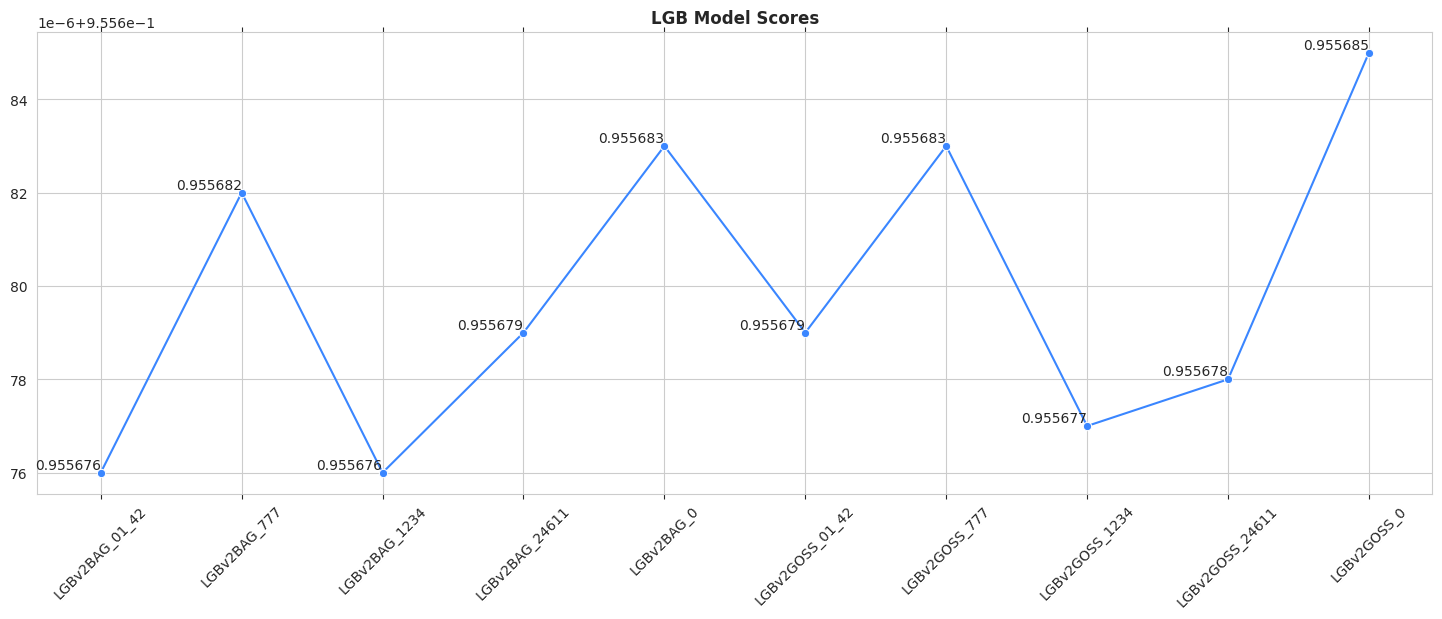

In [35]:
## -- Get Scores --
all_model_scores = {}

for k, v in all_model_predictions.items():
    for x, y in v.items():
        if x == 'score':
            # print(k, y)
            all_model_scores[k] = y

plt.figure(figsize=(18, 6))
sns.lineplot(all_model_scores, marker='o')
# pd.Series(all_model_scores).plot(marker='o')

plt.title('LGB Model Scores', fontweight='semibold')
plt.tick_params('x', rotation=45, reset=True)

for i, score in enumerate(all_model_scores.values()):
    plt.text(float(i), score+2e-7, score, ha='right', va='center_baseline')

plt.show()

In [36]:
## -- Get oof outputs --
all_model_oof = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'oof_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_oof = pd.concat([all_model_oof, pd.DataFrame({n: y})], axis=1)

all_model_oof.to_parquet(f"oof_{version_name}_models.parquet", index=False)
all_model_oof.head()

,LGBv2BAG_01_42_955676,LGBv2BAG_777_955682,LGBv2BAG_1234_955676,LGBv2BAG_24611_955679,LGBv2BAG_0_955683,LGBv2GOSS_01_42_955679,LGBv2GOSS_777_955683,LGBv2GOSS_1234_955677,LGBv2GOSS_24611_955678,LGBv2GOSS_0_955685
0,0.996810,0.997106,0.996695,0.996583,0.996408,0.996692,0.996958,0.996792,0.996849,0.996570
1,0.010915,0.011238,0.011703,0.011474,0.011387,0.011151,0.011503,0.011510,0.011572,0.011580
2,0.011317,0.009965,0.011035,0.010149,0.010768,0.011245,0.010136,0.011182,0.010328,0.010317
3,0.050821,0.049484,0.047942,0.048892,0.050607,0.050094,0.049914,0.048312,0.048319,0.050371
4,0.997181,0.997015,0.996681,0.997013,0.996716,0.996933,0.996935,0.997045,0.997022,0.996965


In [37]:
## -- Get test predictions --
all_model_test = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'test_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_test = pd.concat([all_model_test, pd.DataFrame({n: y})], axis=1)

all_model_test.to_parquet(f"test_{version_name}_models.parquet", index=False)
all_model_test.head()

,LGBv2BAG_01_42_955676,LGBv2BAG_777_955682,LGBv2BAG_1234_955676,LGBv2BAG_24611_955679,LGBv2BAG_0_955683,LGBv2GOSS_01_42_955679,LGBv2GOSS_777_955683,LGBv2GOSS_1234_955677,LGBv2GOSS_24611_955678,LGBv2GOSS_0_955685
0,0.950850,0.950714,0.949169,0.948882,0.948596,0.950606,0.951389,0.949201,0.949233,0.949779
1,0.008924,0.009363,0.008825,0.009642,0.009454,0.008905,0.009378,0.008781,0.009600,0.009564
2,0.989449,0.989072,0.989146,0.988820,0.989266,0.989410,0.989101,0.989140,0.988925,0.989339
3,0.004804,0.005049,0.004813,0.005231,0.005042,0.004825,0.005058,0.004812,0.005250,0.004998
4,0.189936,0.193897,0.196975,0.188004,0.195383,0.191131,0.194538,0.196940,0.187369,0.194835


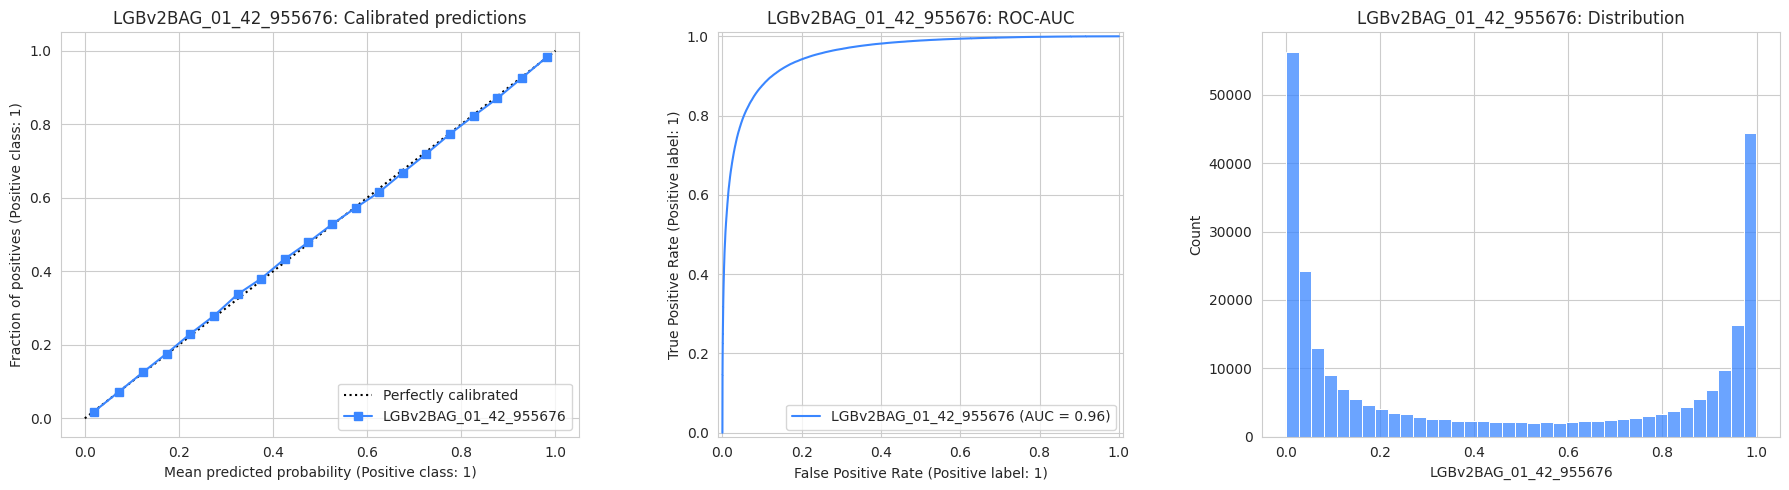

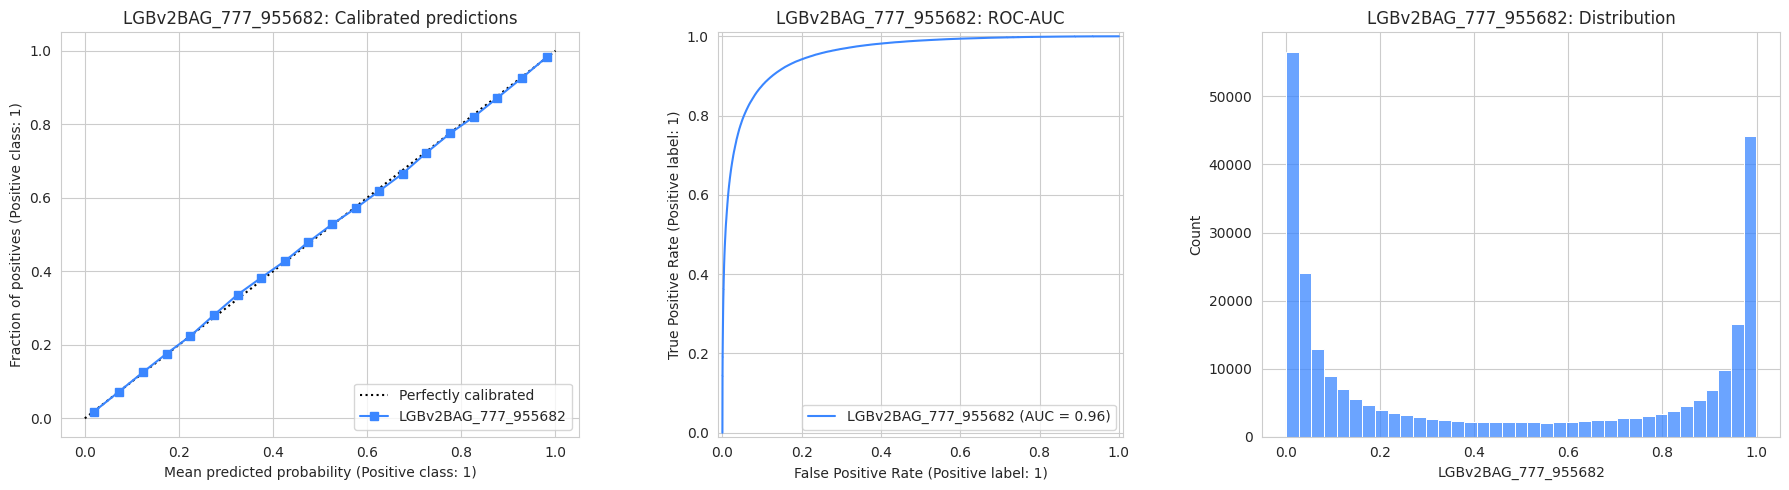

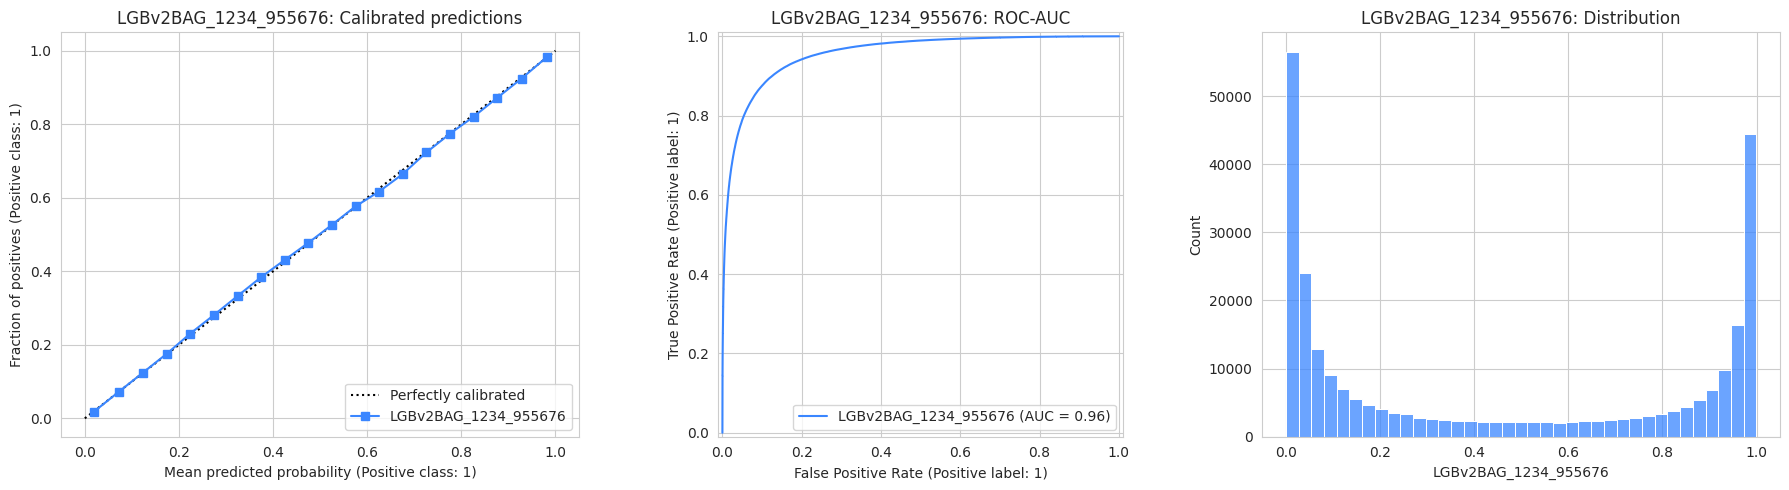

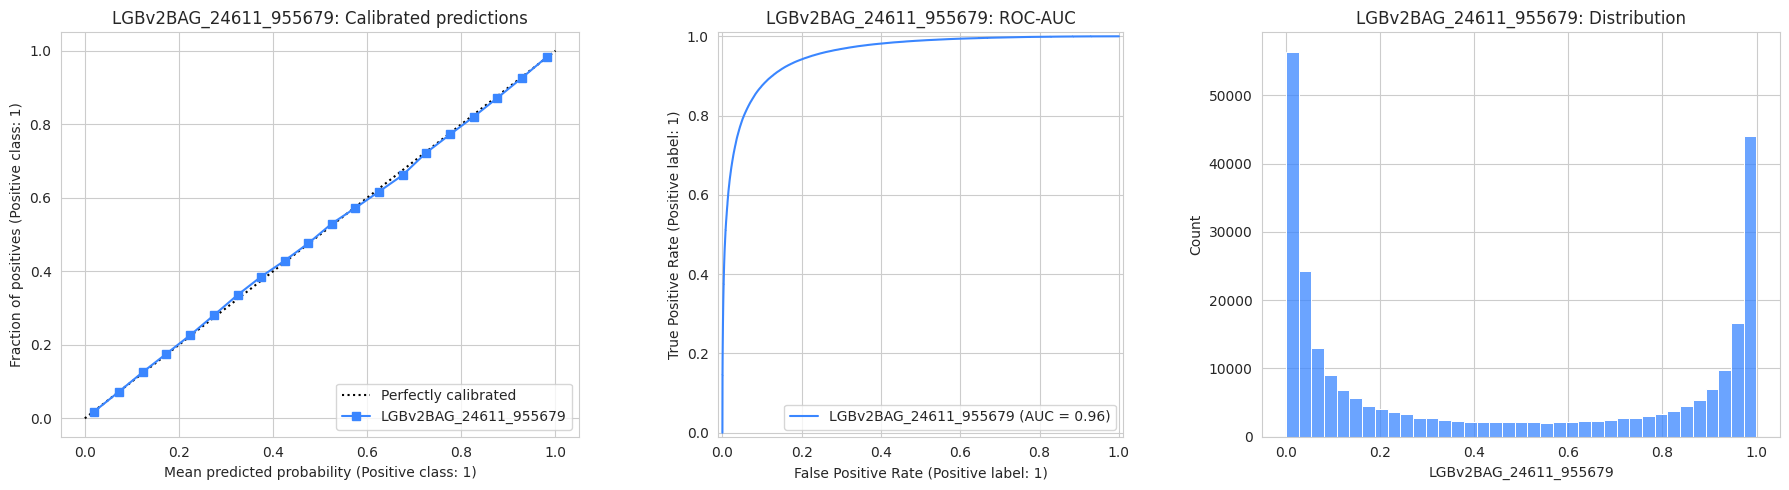

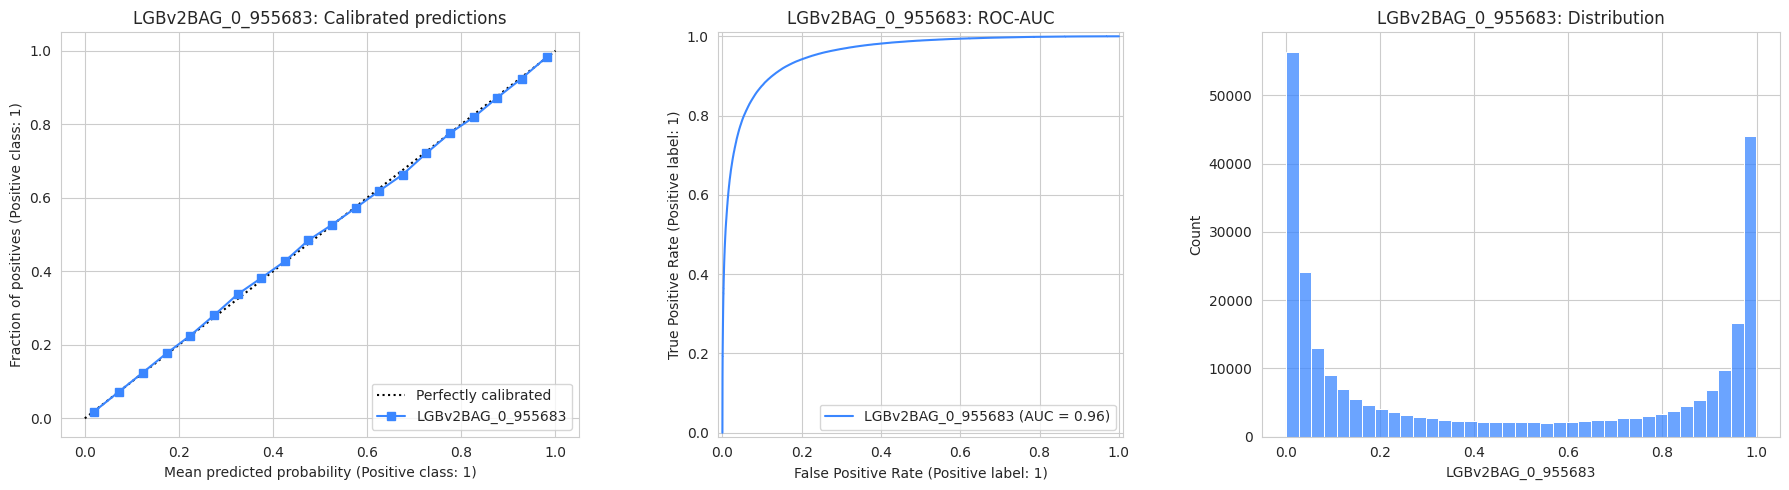

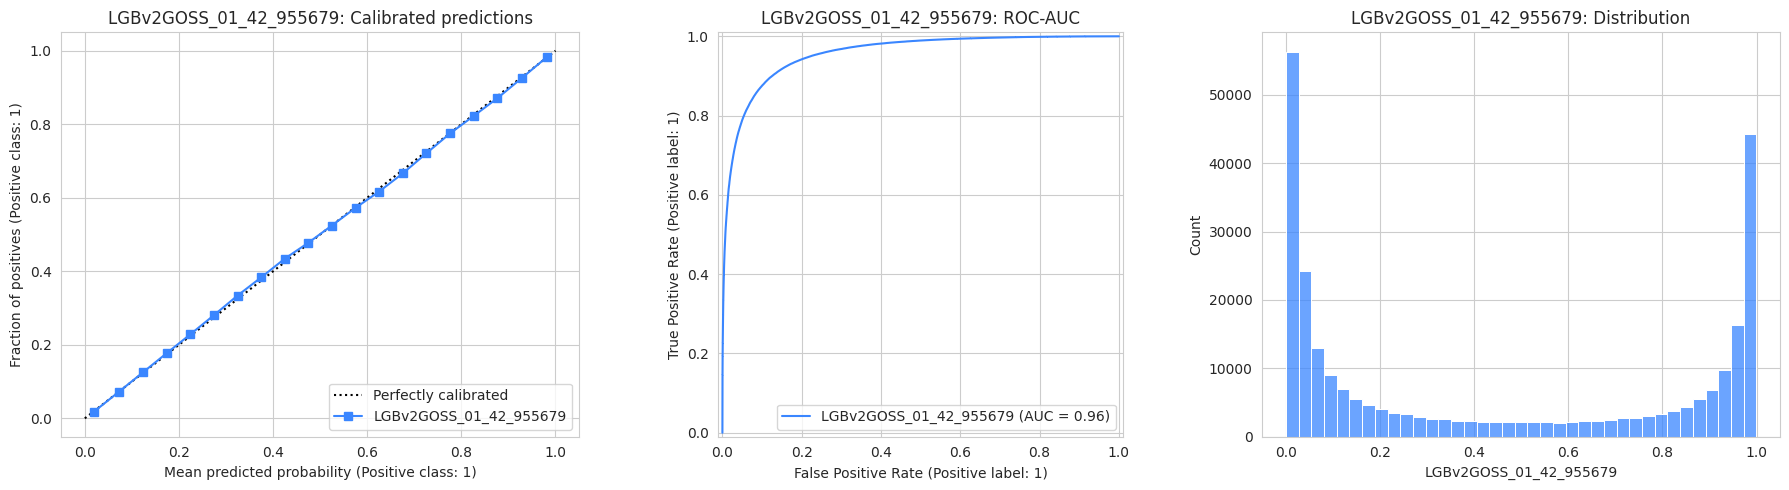

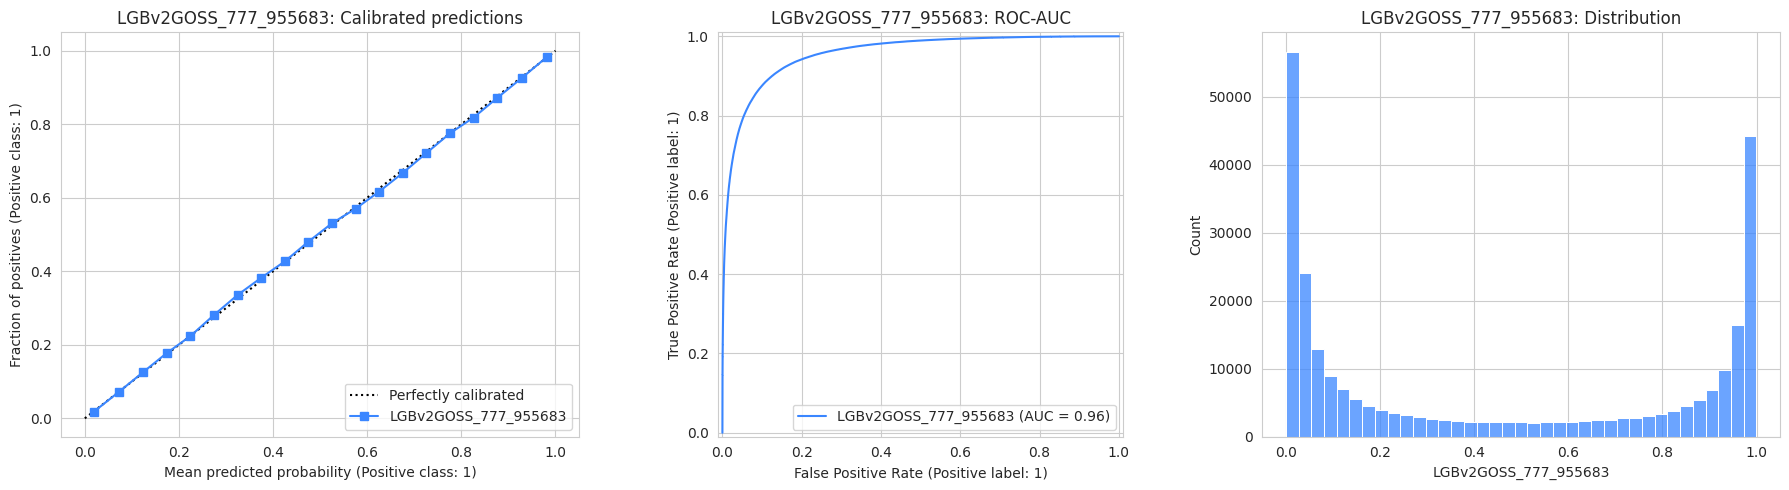

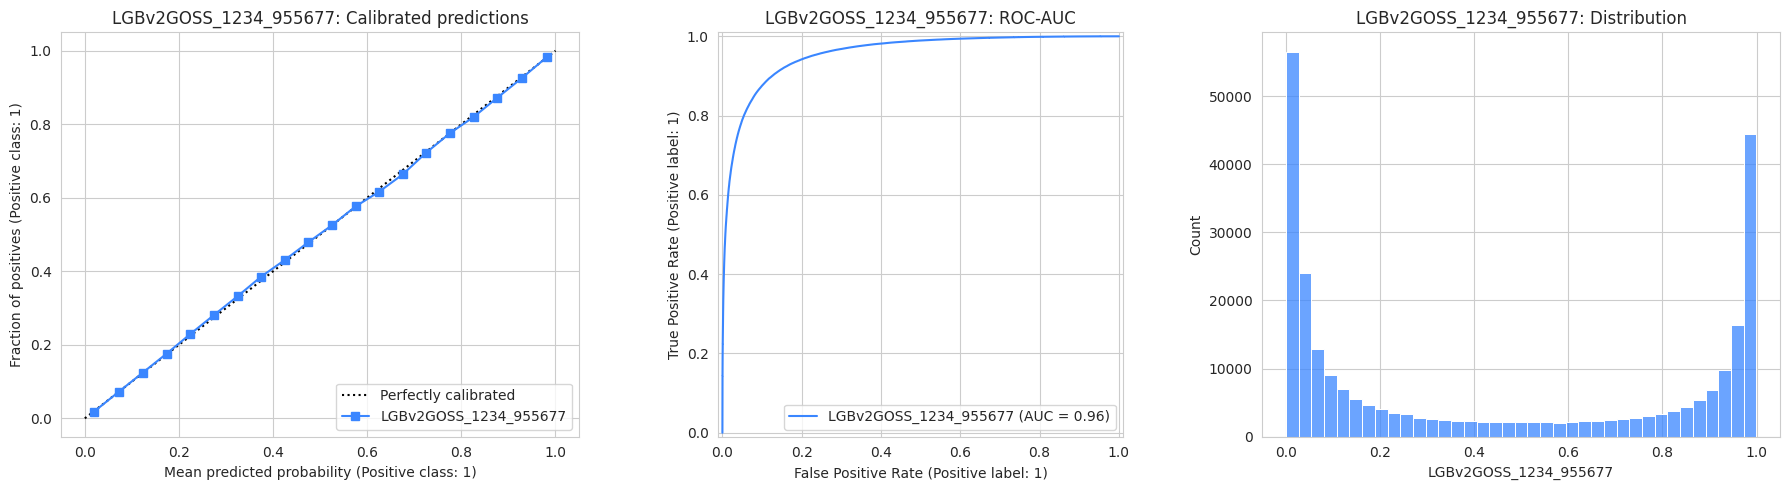

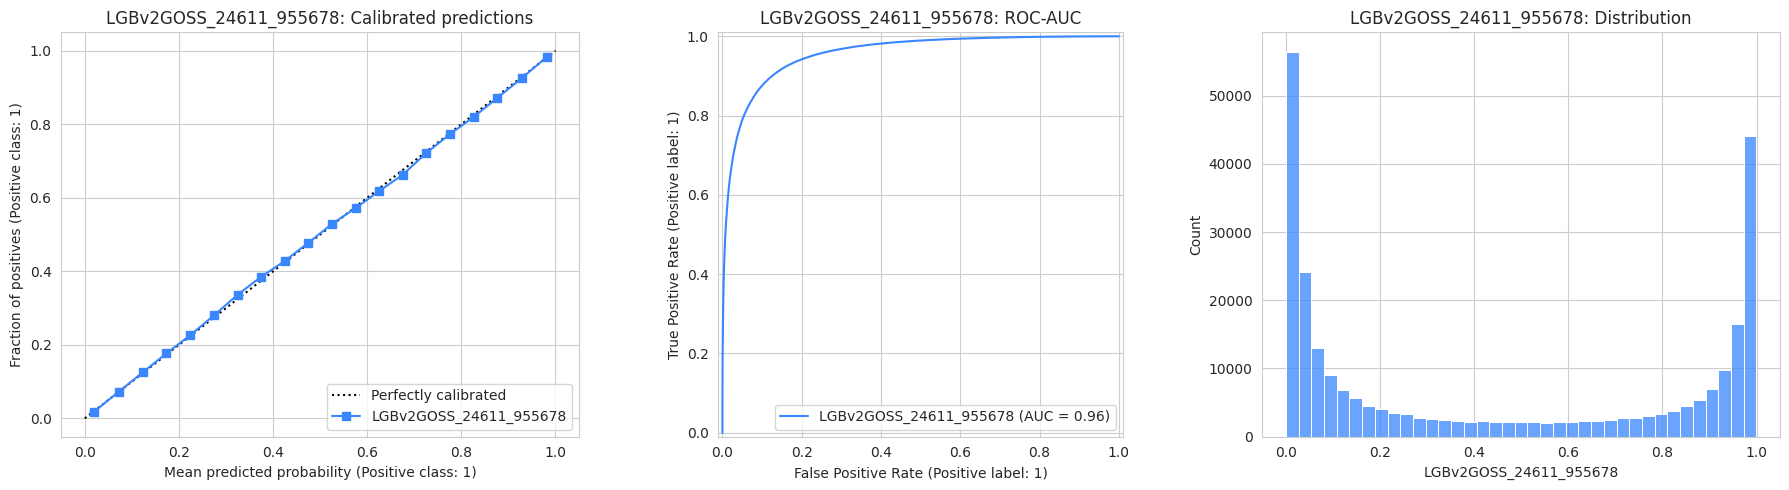

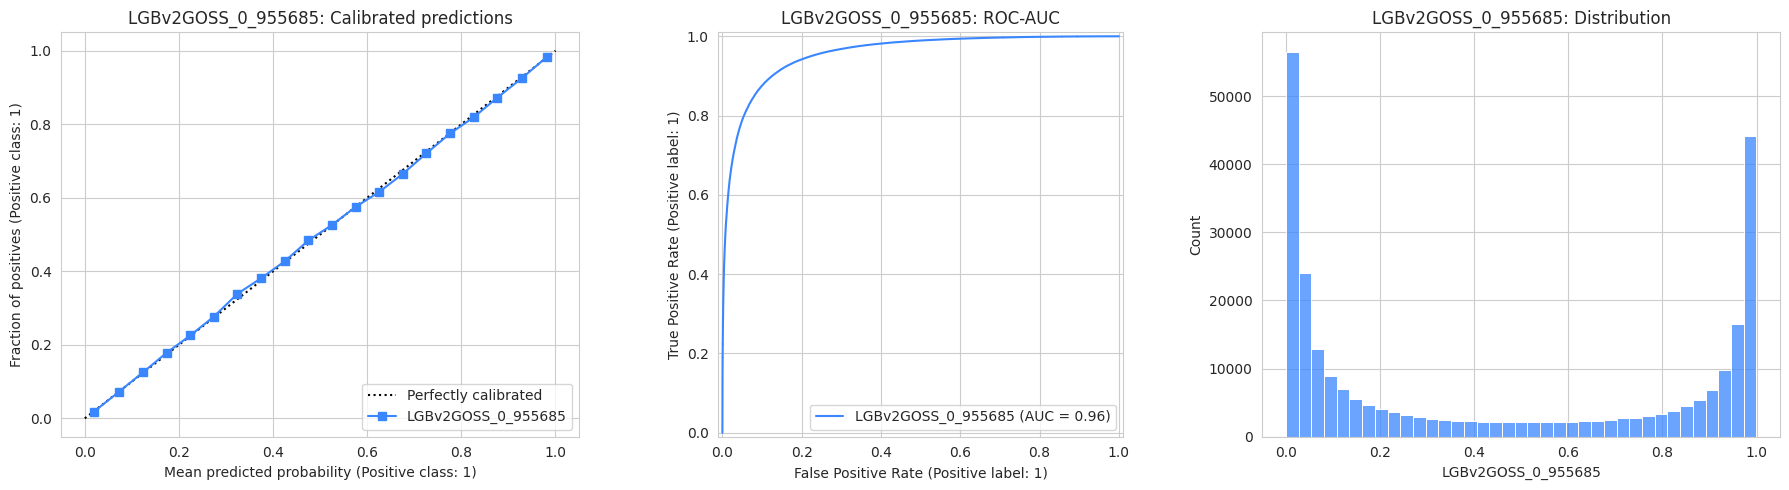

In [38]:
## -- PLOT PREDICTIONS --
for i, n in enumerate(all_model_test.columns):
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) 
    
    CalibrationDisplay.from_predictions(train[TARGET], all_model_oof[n], n_bins=20, name=n, ax=axs[0])
    axs[0].set_title(f"{n}: Calibrated predictions")
    
    RocCurveDisplay.from_predictions(train[TARGET], all_model_oof[n], name=n, ax=axs[1])
    axs[1].set_title(f"{n}: ROC-AUC")
    # axs[1].grid(False)

    sns.histplot(all_model_test[n], ax=axs[2])
    axs[2].set_title(f"{n}: Distribution")
    
    plt.tight_layout()
    plt.show()
    print()

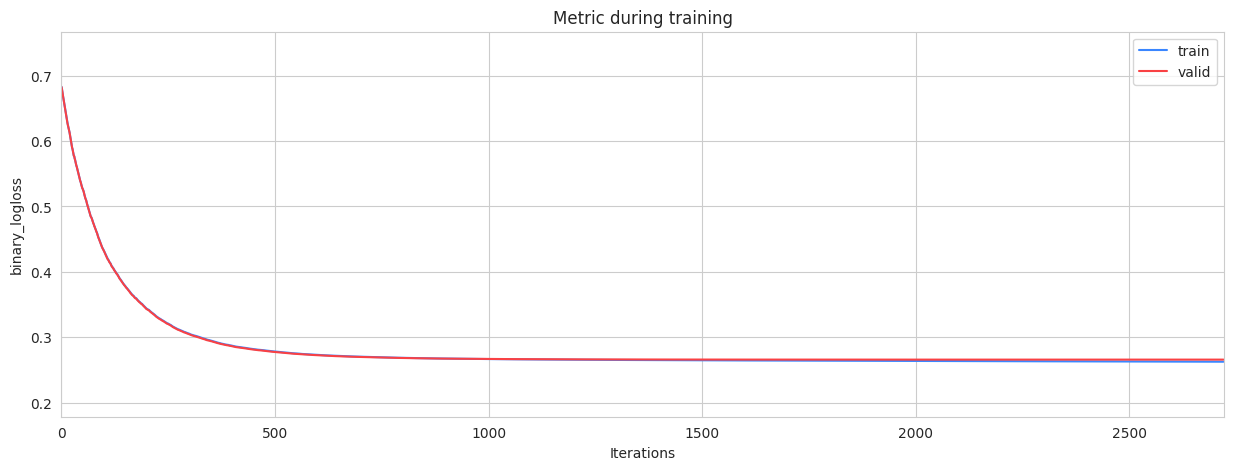

In [39]:
## -- Use any model of choice from keys... 0, 1, 2...
get_model = all_model_predictions[list(all_model_predictions.keys())[0]]

lgb.plot_metric(get_model['records'][0], figsize=(15, 5))
plt.show()

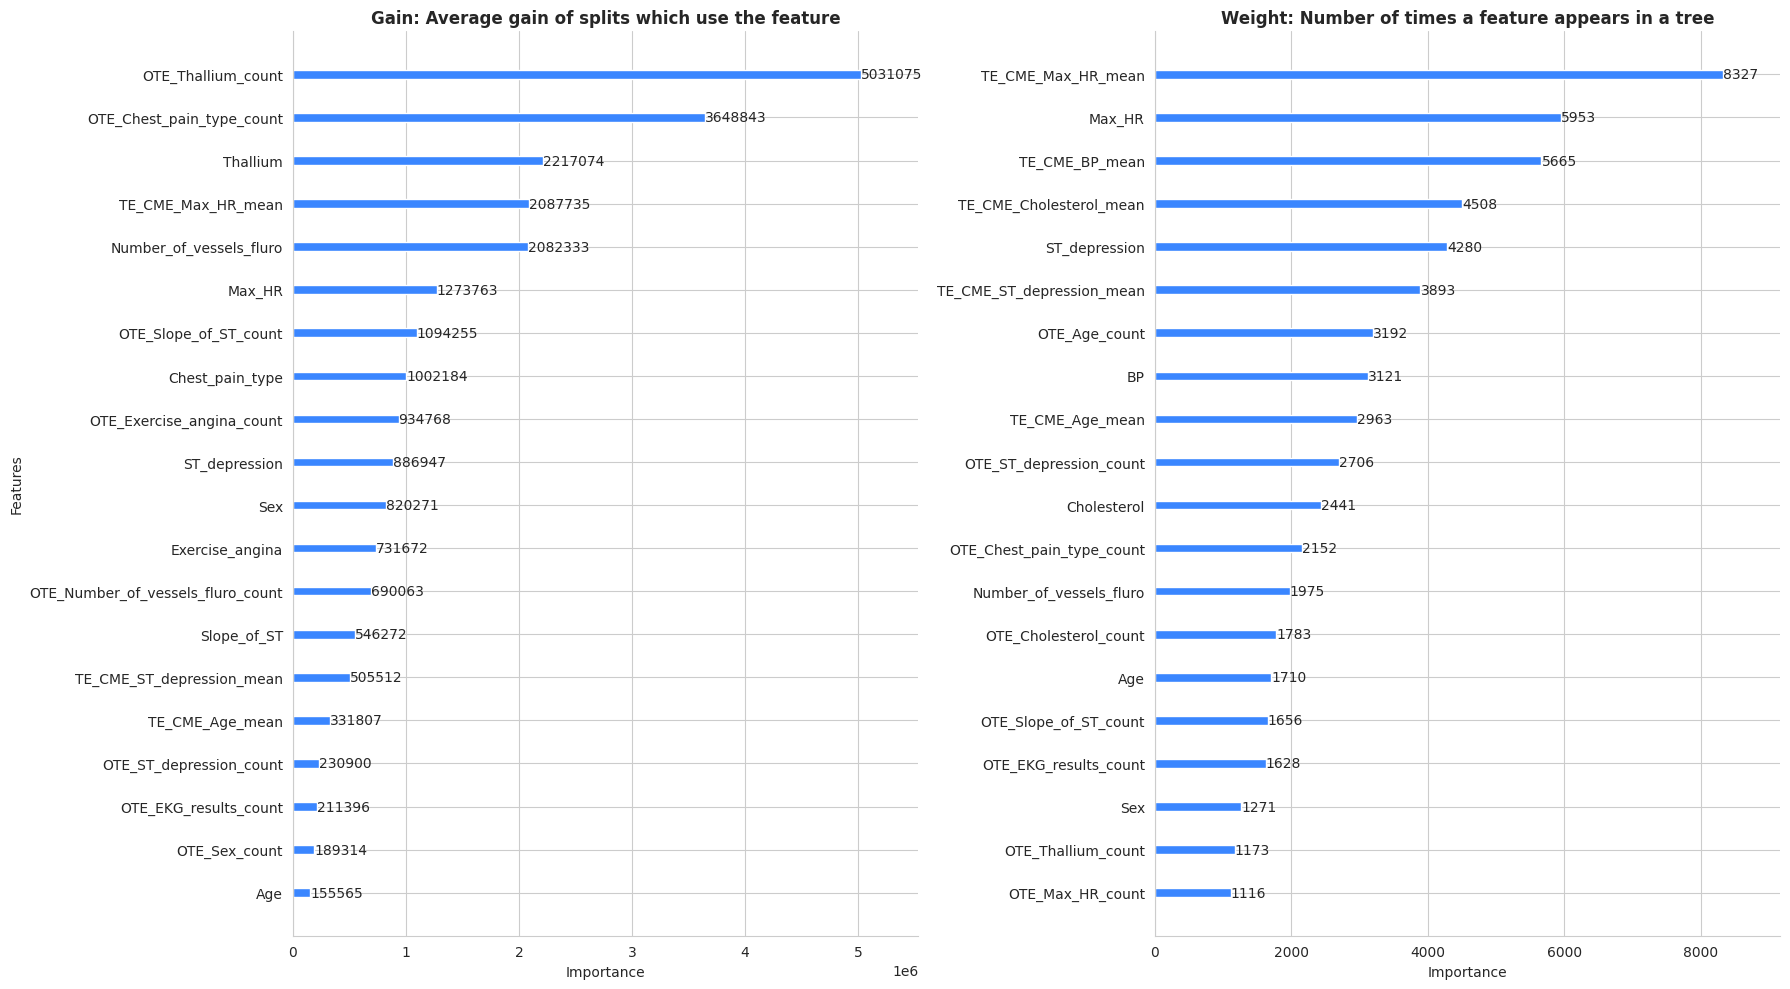

In [40]:
## -- Plot Feature Importances --
MAX = 20

_, axs = plt.subplots(1, 2, figsize=(18, 10))
lgb.plot_importance(
    get_model['model'],
    importance_type='gain',
    max_num_features=MAX,
    precision=0, ax=axs[0], # grid=False,
    # title="Gain: Total gains of splits which use the feature."
)
axs[0].set_title('Gain: Average gain of splits which use the feature', fontweight='semibold')

lgb.plot_importance(
    get_model['model'],
    importance_type='split',
    max_num_features=MAX,
    precision=0, ax=axs[1], # grid=False,
    # title="Split: Number of times the feature is used in a model."
)
axs[1].set_title('Weight: Number of times a feature appears in a tree', fontweight='semibold')
axs[1].set_ylabel('')
                 
for ax in axs:
    ax.set_xlabel('Importance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()
plt.show()